# Description

The main idea is to test the same CNNs that are known to have a good perfomance in medical image segmentation, particularly those that were tested on a retina dataset such as the [DRIVE dataset](https://drive.grand-challenge.org/). After that, the same models will be apply for segmentation of blood vessel in egg embryo.

U-net: This model was based in the paper [U-Net: Convolutional Networks for Biomedical](https://arxiv.org/pdf/1505.04597.pdf).

M2V-net: This model was prepared using a pretrained layers of [MobileNetV2](https://arxiv.org/pdf/1801.04381.pdf) as the enconder, and for the decoder it was used a upsample block implemented in pix2pix. The complete description of this model can be found as an example in [Tensorflow site](https://www.tensorflow.org/tutorials/images/segmentation).

M2U-net: This model was based in this [paper](https://arxiv.org/pdf/1811.07738.pdf), some of the layers are based in the MobileNetV2.

# Mount the Drive and Import

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
!pip install tensorflow_io

In [82]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

In [83]:
print(tf.__version__)

2.15.0


# Parameters, Functions and Classes

## Parameters

In [84]:
# Images parameters
channels = 4
height = 584
width = 565

# Resize parameters
resize_wh = 512
num_crops = 4
crop_wh = resize_wh // num_crops

In [85]:
# File paths
imgs_train = "/content/drive/MyDrive/DRIVE/training/images/"
label_imgs_train = "/content/drive/MyDrive/DRIVE/training/1st_manual/"
masks_train = "/content/drive/MyDrive/DRIVE/training/mask/"

imgs_test = "/content/drive/MyDrive/DRIVE/test/images/"
label_imgs_test = "/content/drive/MyDrive/DRIVE/test/1st_manual/"
masks_test = "/content/drive/MyDrive/DRIVE/test/mask/"

In [86]:
image_paths = [imgs_train + str(i) + '_training.tif' for i in range(21, 41)]
label_paths = [label_imgs_train + str(i) + '_manual1.gif' for i in range(21, 41)]

In [87]:
test_image_paths = [imgs_test + str(i).zfill(2) + '_test.tif' for i in range(1, 21)]
test_label_paths = [label_imgs_test + str(i).zfill(2) + '_manual1.gif' for i in range(1, 21)]

## Functions and Classes

### Plot Utils

In [88]:
def display_image(image):
    """
    Displays a image from a tensor or numpy array.

    Parameters:
    - image (tf.Tensor or numpy array): The image to display.
    """

    # Convert the TensorFlow tensor to a NumPy array and normalize it
    if isinstance(image, tf.Tensor):
        image_array = image.numpy()
    elif isinstance(image, np.ndarray):
        image_array = image

    shape = image_array.shape

    # Check the number of channels and display accordingly
    if len(shape) == 2 or shape[2] == 1:
        plt.imshow(cv2.cvtColor(image_array, cv2.IMREAD_GRAYSCALE))
    else:
        plt.imshow(cv2.cvtColor(image_array, cv2.IMREAD_COLOR))


    plt.axis('off')
    plt.show()

In [89]:
def reconstruct_image(array):
    """
    Reconstructs the image from a (num_crops, num_crops) grid of (crop_wh, crop_wh, num_channels)
    squares using TensorFlow operations.

    Parameters:
        array (numpy array): The input array with shape [num_crops**2, crop_wh, crop_wh, num_channels]

    Returns:
        numpy: Reconstructed image with shape [resize_wh, resize_wh, num_channels]
    """
    num_channels = array.shape[-1]
    num_crops = int(array.shape[0]**0.5)
    crop_wh = array.shape[1]
    resize_wh = num_crops * crop_wh

    # Reshape to [num_crops, num_crops, crop_wh, crop_wh, num_channels]
    array = array.reshape([num_crops, num_crops, crop_wh, crop_wh, num_channels])

    # Transpose to [num_crops, crop_wh, num_crops, crop_wh, num_channels]
    array = array.transpose([0, 2, 1, 3, 4])

    # Reshape to final size [resize_wh, resize_wh, num_channels]
    reconstructed_image = array.reshape([resize_wh, resize_wh, num_channels])

    return reconstructed_image

In [90]:
import matplotlib.pyplot as plt
import numpy as np

def plot_segmentation_results(ground_truth, prediction, threshold=0.5):
    # Remove singleton dimensions and convert to binary labels based on the threshold
    ground_truth = ground_truth.squeeze()
    prediction = prediction.squeeze()

    binary_ground_truth = (ground_truth > threshold).astype(int)
    binary_prediction = (prediction > threshold).astype(int)

    # Calculate True Positives
    true_positives = np.logical_and(binary_ground_truth == 1, binary_prediction == 1)

    # Calculate False Positives
    false_positives = np.logical_and(binary_ground_truth == 0, binary_prediction == 1)

    # Initialize an overlay with 3 color channels (red, green, blue)
    overlay = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 3), dtype=np.uint8)

    overlay[binary_ground_truth == 1] = [255, 255, 255]

    overlay[true_positives] = [0, 0, 255]

    overlay[false_positives] = [255, 0, 0]

    # Create plot
    plt.figure(figsize=(10, 10))

    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')

    plt.show()

### Preprocessing

**Steps:**

1. Load images and labels from paths.
2. Normalize the images.
3. Use Clahe Equalization. (Optional)(Output a grayscale image)
4. Resize the image to (`resize_wh`, `resize_wh`).
5. Crop the images in `num_crops`^2. (Optional)(Just to save VRAM)
6. Split the dataset in train and validation.

### Augmentation

**Steps:**

1. Random brightness.
2. Random contrast.
3. Random saturation.
4. Random hue.

In [91]:
import tensorflow as tf
import tensorflow_io as tfio
import cv2
import numpy as np
import matplotlib.pyplot as plt

class DatasetPreprocess:

    def __init__(self, image_paths, label_paths, output_type,
                 batch_size=32,
                 resize_wh=512, num_crops=4,
                 split_dataset=True, is_test=False):
        """
        Initializes the pipeline and builds it.

        Parameters:
        image_paths (list): List of paths to image files.
        label_paths (list): List of paths to label files.
        batch_size (int, optional): Size of the batches. Defaults to 32.
        resize_wh (int, optional): Dimensions for resizing images. Defaults to 512.
        num_crops (int, optional): Number o cropped images in each dimension. Defaults to 4.
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.resize_wh = resize_wh
        self.num_crops = num_crops
        self.split_dataset = split_dataset
        self.shuffle_buffer = len(image_paths) * (self.num_crops)**2
        self.is_test = is_test
        self.output_type = output_type

        self._build_pipeline()

    def _build_pipeline(self):
        """Builds the preprocessing pipeline."""
        self.dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

        self.dataset = self.dataset.map(self._load_images_and_labels)
        if ~self.is_test:
            self.dataset = self.dataset.map(self._augment)
        self.dataset = self.dataset.map(self._preprocess)

        self.dataset = self.dataset.map(self._crop_images_labels)
        self.dataset = self.dataset.flat_map(
            lambda image, label: tf.data.Dataset.zip((
            tf.data.Dataset.from_tensor_slices(image),
            tf.data.Dataset.from_tensor_slices(label))
            ))

        if self.split_dataset:

            self.train_dataset, self.test_dataset = self._split_dataset(self.dataset, 0.1)

            self.train_dataset = self.train_dataset\
                                    .shuffle(self.shuffle_buffer)\
                                    .batch(self.batch_size)\
                                    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

            self.test_dataset = self.test_dataset\
                                    .batch(self.batch_size)\
                                    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        else:

          if self.is_test:
              self.dataset = self.dataset\
                                 .batch(self.num_crops**2)\
                                 .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
          else:
              self.dataset = self.dataset\
                                 .shuffle(self.shuffle_buffer)\
                                 .batch(self.batch_size)\
                                 .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    def get_train_test(self):
      return self.train_dataset, self.test_dataset

    def get_dataset(self):
      return self.dataset

    def _load_images_and_labels(self, image_paths, label_paths):
        """Loads an image and label from the given paths."""
        image_string, label_string = tf.io.read_file(image_paths), tf.io.read_file(label_paths)

        image = tfio.experimental.image.decode_tiff(image_string)
        label = tf.squeeze(tf.image.rgb_to_grayscale(tf.image.decode_gif(label_string)), axis=0)

        image, label = tf.cast(image, tf.float32), tf.cast(label, tf.float32)

        return image, label

    def _normalize(self, image, label):

        mean = 83.15841582964605
        std = 57.07514784246855

        image = (image - mean) / std

        max = tf.math.reduce_max(image)
        min = tf.math.reduce_min(image)

        image = 255 * (image - min) / (max - min)

        return image, label

    def clahe_equalized(self, image):

        image = tf.image.rgb_to_grayscale(image[:, :, :3])
        image = image.numpy()

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image.astype(np.uint8))
        image = np.expand_dims(image, axis=-1)

        return image

    def _preprocess(self, image, label):
        """Applies data preprocessing to the image and label.

           Warning: Outputs a image in grayscale due to clahe_equalized.
        """

        image, label = self._normalize(image, label)

        if self.output_type == 'grayscale':
          shape = image.shape
          image = tf.py_function(self.clahe_equalized, [image], tf.uint8)
          image.set_shape([shape[0], shape[1], 1])
          print('Output a 1 channel image. (grayscale)')
        elif self.output_type == 'color':
          print('Output a 3 channel image.')
        else:
          print('Choose a output type: [grayscale, color]')
          return

        image = tf.image.resize(image, [resize_wh, resize_wh], method='nearest')
        image = image / tf.reduce_max(image)

        label = tf.image.resize(label, [resize_wh, resize_wh], method='nearest') / 255

        return image, label

    def _augment(self, image, label):
        """Applies data augmentation to the image and label.

           Warning: Discard the last channel (alpha).
        """
        image = image[..., :3]

        shape = image.shape
        image.set_shape([shape[0], shape[1], 3])

        ran = tf.random.uniform([2], minval=1 - 0.3, maxval=1 + 0.3)

        image = tf.image.adjust_brightness(image, ran[0])
        image = tf.image.adjust_contrast(image, ran[1])

        ran = tf.random.uniform([2], minval=1 - 0.02, maxval=1 + 0.02)

        image = tf.image.adjust_saturation(image, ran[0])
        image = tf.image.adjust_hue(image, ran[1])

        return image, label

    def _crop_images_labels(self, image, label):

        cropped_image = self._crop_image(image, self.num_crops)
        cropped_label = self._crop_image(label, self.num_crops)

        return cropped_image, cropped_label

    def _crop_image(self, image, num_crops):
        """
        crops a batch of images into (num_crops, num_crops) small images
        with size of height // num_crops.

        Parameters:
        image (Tensor): Input image tensor of shape (B, H, W, C)
        num_crops (int): The number of crops along each dimension

        Returns:
        List[Tensor]: A list containing num_crops^2 image tensors.
        """

        image = tf.expand_dims(image, axis=0)

        batch_size, height, width, channels = image.shape
        patch_size = height // num_crops

        if height % num_crops != 0 or width % num_crops != 0:
            raise ValueError("Image dimensions must be divisible by num_crops")

        # Use tf.image.extract_patches to extract patches
        patches = tf.image.extract_patches(
            images=image,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )

        # Reshape the patches to separate them
        patches_shape = tf.shape(patches)
        num_patches = num_crops * num_crops

        patches = tf.reshape(patches, [num_patches, patch_size, patch_size, channels])

        return patches

    def _split_dataset(self, dataset, validation_data_fraction):
        """
        Splits a dataset of type tf.data.Dataset into a training and validation dataset using a given ratio.

        Parameters:
        - dataset (tf.data.Dataset): The input dataset to split.
        - validation_data_fraction (float): The fraction of the validation data, must be a float between 0 and 1.

        Returns:
        Tuple[tf.data.Dataset, tf.data.Dataset]: A tuple containing the training and validation datasets.
        """

        MAX_PERCENT = 100  # Maximum allowable percentage value
        validation_data_percent = round(validation_data_fraction * MAX_PERCENT)

        if not (0 <= validation_data_percent <= MAX_PERCENT):
            raise ValueError("Validation data fraction must be a value between 0 and 1.")

        dataset = dataset.enumerate()
        train_dataset = dataset.filter(lambda f, data: f % MAX_PERCENT > validation_data_percent)
        validation_dataset = dataset.filter(lambda f, data: f % MAX_PERCENT <= validation_data_percent)

        # Remove enumeration
        train_dataset = train_dataset.map(lambda f, data: data)
        validation_dataset = validation_dataset.map(lambda f, data: data)

        return train_dataset, validation_dataset

In [92]:
from tensorflow.keras import layers

class random_flip_rot(layers.Layer):
  def __init__(self, rot90_prob=0.15, flip_prob=0.15):
    super().__init__()
    self.flip_left_right = tf.image.flip_left_right
    self.flip_up_down = tf.image.flip_up_down
    self.rot_inputs = tf.image.rot90
    self.rot90_prob = rot90_prob
    self.flip_prob = flip_prob

  def call(self, inputs, labels):

    ran = tf.random.uniform([2], maxval=1)

    if ran[0] < self.flip_prob:

      ran_flip = tf.random.uniform([1], maxval=1)

      if ran_flip[0] < 0.5:
        inputs = self.flip_left_right(inputs)
        labels = self.flip_left_right(labels)
      else:
        inputs = self.flip_up_down(inputs)
        labels = self.flip_up_down(labels)

    if ran[1] < self.rot90_prob:
      rand_k = tf.random.uniform([1], minval=1, maxval=4, dtype=tf.int32)
      inputs = self.rot_inputs(inputs, k=rand_k[0])
      labels = self.rot_inputs(labels, k=rand_k[0])

    return inputs, labels

### U-Net

In [93]:
from tensorflow.keras.layers import (Conv2D, BatchNormalization,
                                    Activation, MaxPool2D, Conv2DTranspose,
                                    Concatenate, Input)

from tensorflow.keras.models import Model

from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D,
                                     Conv2DTranspose, Activation,
                                     BatchNormalization, Concatenate)

from tensorflow.keras.models import Model

class UNet:

    def __init__(self, image_height, image_width, n_ch):
        self.image_height = image_height
        self.image_width = image_width
        self.n_ch = n_ch
        self.model = self.build_unet()

    def build(self):
        return self.model

    def build_unet(self):
        """
        Build the complete U-Net model.

        Parameters:
            patch_height (int): Height of the input patch.
            patch_width (int): Width of the input patch.
            n_ch (int): Number of channels in the input.

        Returns:
            Model: The complete U-Net model.
        """
        input = Input(shape=(self.image_height, self.image_width, self.n_ch))
        x, encoder_outputs = self.encoder(input)
        bottleneck = self.bottle_neck(x)
        output = self.decoder(bottleneck, encoder_outputs, 1)
        model = Model(inputs=input, outputs=output)
        return model

    def conv2d_block(self, input, n_filters, kernel_size=3, activation='relu'):
        """
        Create a 2D convolution block with batch normalization and activation.

        Parameters:
            input (tensor): Input tensor to the block.
            n_filters (int): Number of filters.
            kernel_size (int): Kernel size. Default is 3.
            activation (str): Activation function. Default is 'relu'.

        Returns:
            tensor: Output tensor from the block.
        """
        x = input
        for i in range(2):
            x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                       activation=None, padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation(activation)(x)
        return x

    def one_encoder_block(self, input, n_filters):
        """
        Create one encoder block with MaxPooling.

        Parameters:
            input (tensor): Input tensor to the block.
            n_filters (int): Number of filters.

        Returns:
            tuple: Two tensors. First is the output tensor from the block, and second is the tensor after MaxPooling.
        """
        f = self.conv2d_block(input, n_filters)
        x = MaxPool2D(pool_size=(2, 2))(f)
        return f, x

    def one_decoder_block(self, inputs, decoder_output, n_filters, kernel_size=3):
        """
        Create one decoder block with Conv2DTranspose and Concatenation.

        Parameters:
            inputs (tensor): Input tensor to the block.
            decoder_output (tensor): Output tensor from the corresponding encoder to be concatenated.
            n_filters (int): Number of filters.
            kernel_size (int): Kernel size. Default is 3.

        Returns:
            tensor: Output tensor from the block.
        """
        f = Conv2DTranspose(filters=n_filters,
                            kernel_size=(kernel_size, kernel_size),
                            padding='same',
                            strides=(2, 2))(inputs)
        f = Concatenate()([f, decoder_output])
        f = self.conv2d_block(f, n_filters, kernel_size=3)
        return f

    def encoder(self, inputs):
        """
        Create the encoder part of the U-Net.

        Parameters:
            inputs (tensor): Input tensor to the encoder.

        Returns:
            tuple: Two elements. First is the output tensor from the last encoder block, and second is a tuple containing output tensors from all encoder blocks.
        """
        f1, x = self.one_encoder_block(inputs, 32)
        f2, x = self.one_encoder_block(x, 64)
        f3, x = self.one_encoder_block(x, 128)
        return x, (f1, f2, f3)

    def bottle_neck(self, input, n_filters=256):
        """
        Create the bottleneck part of the U-Net.

        Parameters:
            input (tensor): Input tensor to the bottleneck.
            n_filters (int): Number of filters. Default is 256.

        Returns:
            tensor: Output tensor from the bottleneck.
        """
        f = self.conv2d_block(input, n_filters)
        return f

    def decoder(self, inputs, encoder_outputs, n_labels):
        """
        Create the decoder part of the U-Net.

        Parameters:
            inputs (tensor): Input tensor to the decoder.
            encoder_outputs (tuple): Tuple of output tensors from the encoder to be used for concatenation.
            n_labels (int): Number of labels in the output.

        Returns:
            tensor: Output tensor from the decoder.
        """
        f1, f2, f3 = encoder_outputs
        x = self.one_decoder_block(inputs, f3, n_filters=128, kernel_size=3)
        x = self.one_decoder_block(x, f2, n_filters=64, kernel_size=3)
        x = self.one_decoder_block(x, f1, n_filters=32, kernel_size=3)
        outputs = Conv2D(n_labels, (1, 1), activation='sigmoid')(x)
        return outputs


### MV2

In [94]:
!pip install tensorflow-examples


In [95]:
!pip install -q git+https://github.com/tensorflow/examples.git


  Preparing metadata (setup.py) ... done


In [96]:
from tensorflow.keras.layers import Input, concatenate, BatchNormalization, \
                                    Conv2D, MaxPooling2D, MaxPool2D, \
                                    UpSampling2D, Reshape, Dropout, Reshape, \
                                    Permute, Activation, Conv2DTranspose,  \
                                    Concatenate
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

!pip install -q git+https://github.com/tensorflow/examples.git

class MV2Transfer:
    def __init__(self, height, width, output_channels):
        self.height = height
        self.width = width
        self.output_channels = output_channels
        self.down_stack = self.build_down_stack()
        self.up_stack = self.build_up_stack()
        self.model = self.build_unet_M2V()

    def build(self):
        return self.model

    def build_down_stack(self):
        base_model = tf.keras.applications.MobileNetV2(input_shape=[self.height, self.width, 3], include_top=False)
        layer_names = [
            'block_1_expand_relu',
            'block_3_expand_relu',
            'block_6_expand_relu',
            'block_13_expand_relu',
            'block_16_project',
        ]
        layers = [base_model.get_layer(name).output for name in layer_names]
        down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
        down_stack.trainable = False
        return down_stack

    def build_up_stack(self):
        return [
            pix2pix.upsample(512, 3),
            pix2pix.upsample(256, 3),
            pix2pix.upsample(128, 3),
            pix2pix.upsample(64, 3),
        ]

    def build_unet_M2V(self):
        last = Conv2DTranspose(
            self.output_channels, 3, strides=2,
            padding='same', activation='sigmoid')

        inputs = Input(shape=[self.height, self.width, 3])
        x = inputs
        skips = self.down_stack(x)
        x = skips[-1]
        skips = reversed(skips[:-1])

        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = Concatenate()([x, skip])

        x = last(x)
        return tf.keras.Model(inputs=inputs, outputs=x)

  Preparing metadata (setup.py) ... done


In [97]:
import tensorflow as tf

class MV2:

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def DepthwiseConv(self, input, channels, stride=1):
        x = tf.keras.layers.DepthwiseConv2D(kernel_size=3,
                                            strides=stride,
                                            padding='same')(input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        x = tf.keras.layers.Conv2D(channels, 1, strides=1, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        return x

    def bottleneck_block(self, input, input_channels, output_channels, stride, factor):
        x = tf.keras.layers.Conv2D(round(input_channels * factor), 1, strides=1, padding='same')(input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        x = self.DepthwiseConv(x, output_channels, stride)
        return x

    def res_bottle_neck(self, input, channels, factor):
        x = tf.keras.layers.Conv2D(round(channels * factor), 1, strides=1, padding='same')(input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        x = self.DepthwiseConv(x, channels, 1)
        x = tf.keras.layers.Add()([x, input])
        return x

    def upconcat(self, input, skip_input):
        x = tf.keras.layers.UpSampling2D(interpolation='bilinear')(input)
        x = tf.concat([x, skip_input], axis=-1)
        return x

    def build(self):
        input = tf.keras.layers.Input(shape=self.input_shape)

        x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)

        skip1 = self.DepthwiseConv(x, channels=16, stride=1)

        x = self.bottleneck_block(skip1, 16, 24, 2, 6)
        skip2 = self.res_bottle_neck(x, 24, 6)

        x = self.bottleneck_block(skip2, 24, 32, 2, 6)
        x = self.res_bottle_neck(x, 32, 6)
        skip3 = self.res_bottle_neck(x, 32, 6)

        x = self.bottleneck_block(skip3, 32, 64, 2, 6)
        x = self.res_bottle_neck(x, 64, 6)
        x = self.res_bottle_neck(x, 64, 6)
        x = self.res_bottle_neck(x, 64, 6)
        x = self.bottleneck_block(x, 64, 96, 1, 6)

        x = self.res_bottle_neck(x, 96, 6)
        x = self.res_bottle_neck(x, 96, 6)

        x = self.upconcat(x, skip3)
        x = self.bottleneck_block(x, 128, 64, 1, 0.15)

        x = self.upconcat(x, skip2)
        x = self.bottleneck_block(x, 88, 44, 1, 0.15)

        x = self.upconcat(x, skip1)
        x = self.bottleneck_block(x, 60, 30, 1, 0.15)

        x = self.upconcat(x, input)
        x = self.bottleneck_block(x, 30, 1, 1, 0.15)

        x = tf.keras.activations.sigmoid(x)

        return tf.keras.Model(inputs=input, outputs=x)

### Jaccard and Dice

In [98]:
def jaccard(y_true, y_pred, smooth=1e-6):
    """
    Calculate the Jaccard index (IoU) between y_true and y_pred.

    Parameters:
        y_true (Tensor): Ground truth label.
        y_pred (Tensor): Predicted label.
        smooth (float): Smoothing constant to prevent division by zero.

    Returns:
        float: Jaccard index.
    """
    # Flatten tensors and calculate intersection and union
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)

def dice(y_true, y_pred, smooth=1e-6):
    """
    Calculate the Sørensen–Dice coefficient between y_true and y_pred.

    Parameters:
        y_true (Tensor): Ground truth label.
        y_pred (Tensor): Predicted label.
        smooth (float): Smoothing constant to prevent division by zero.

    Returns:
        float: Dice coefficient.
    """
    # Flatten tensors and calculate intersection
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    return (2 * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

### Callbacks

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.metrics import roc_auc_score

class CustomCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to display image predictions and metrics at the end of each epoch.

    Parameters:
        model (Model): Keras model instance.
        dataset (tf.data.Dataset): Dataset to evaluate the model.
        display_freq (int): Frequency of display in epochs.
    """
    def __init__(self, model, dataset, display_freq=9):
        self.model = model
        self.dataset = dataset
        self.display_freq = display_freq

    def display_image_from_tensor(self, image_tensor):
        """
        Displays a TensorFlow image from the tensor.

        Parameters:
        - image_tensor (tf.Tensor): The image tensor to display.
        """

        # Convert the TensorFlow tensor to a NumPy array and normalize it
        image_array = image_tensor.numpy().astype("uint8")

        # Get the shape of the image array
        shape = image_array.shape

        # Check the number of channels and display accordingly
        if len(shape) == 2 or shape[2] == 1:  # Grayscale image
            plt.imshow(image_array, cmap='gray')
        else:  # Color image
            plt.imshow(image_array)

        plt.axis('off')

    def plot_images(self, true_label, pred_label):
        """Plot the true and predicted labels."""
        plt.figure(figsize=(10, 10))

        ax = plt.subplot(2, 2, 1)
        self.display_image_from_tensor(true_label)
        plt.title('True')

        ax = plt.subplot(2, 2, 2)
        plt.imshow(cv2.cvtColor(pred_label.astype('float32'), cv2.IMREAD_COLOR))
        plt.title('Predicted')
        plt.axis('off')

        plt.show()

    def calculate_metrics(self, true_label, pred_label):
        """Calculate and print jaccard and dice metrics."""
        jac = jaccard(true_label, tf.convert_to_tensor(pred_label)).numpy()
        dic = dice(true_label, tf.convert_to_tensor(pred_label)).numpy()

        print(f'\nJaccard: {jac:.2f}')
        print(f'Dice: {dic:.2f}\n')

    def on_epoch_end(self, epoch, logs=None):
        """Actions to take at the end of each epoch."""
        if epoch % self.display_freq == 0:
            # Plot sample images
            for data in self.dataset.take(1):
                image, label = data
                pred = self.model.predict(image)

                self.plot_images(label[0, ...], pred[0, ...])
                self.calculate_metrics(label, pred)

### Combined Loss

In [100]:
def combined_loss(y_true, y_pred):

  jac = jaccard(y_true, y_pred)

  jac = (1 - jac)

  loss = (tf.keras.losses.binary_crossentropy(y_true, y_pred) +
        0.3 * jac)

  return loss

# U-Net

## Preprocess and Display Images

In [101]:
data = DatasetPreprocess(image_paths, label_paths, output_type='grayscale',
                         batch_size=32, resize_wh=512, num_crops=4,)
train, test = data.get_train_test()

Output a 1 channel image. (grayscale)


In [102]:
# Create an iterator
dataset_iterator = iter(train)

# Fetch one image-label pair
image, label = next(dataset_iterator)

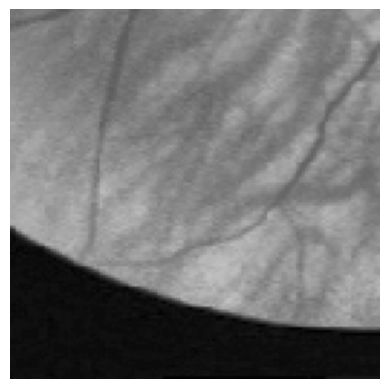

In [103]:
display_image(image[0, ...])

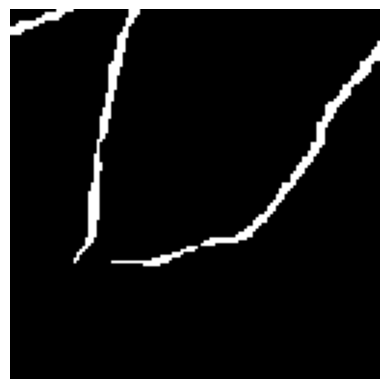

In [104]:
display_image(label[0, ...])

## Build and Compile

In [105]:
model = UNet(crop_wh, crop_wh, 1).build()

In [106]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [107]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_31 (Conv2D)          (None, 128, 128, 32)         320       ['input_10[0][0]']            
                                                                                                  
 batch_normalization_32 (Ba  (None, 128, 128, 32)         128       ['conv2d_31[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 128, 128, 32)         0         ['batch_normalization_32

## Train

In [108]:
save_path = 'Unet_DRIVE.h5'
save_best_only = True

In [109]:
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

Epoch 1/150
1/1 [==============================] - 1s 832ms/step


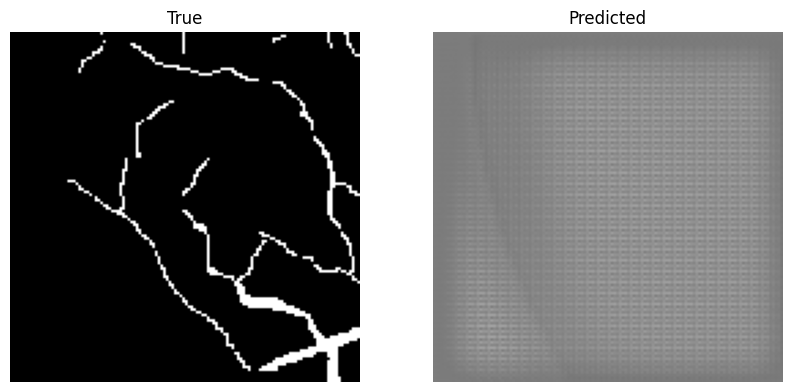


Jaccard: 0.08
Dice: 0.15


Epoch 1: val_loss improved from inf to 0.77413, saving model to Unet_DRIVE.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 - 23s - loss: 0.7615 - accuracy: 0.5957 - val_loss: 0.7741 - val_accuracy: 0.2426 - 23s/epoch - 3s/step
Epoch 2/150

Epoch 2: val_loss did not improve from 0.77413
9/9 - 7s - loss: 0.4284 - accuracy: 0.9152 - val_loss: 5.1488 - val_accuracy: 0.3155 - 7s/epoch - 737ms/step
Epoch 3/150

Epoch 3: val_loss did not improve from 0.77413
9/9 - 4s - loss: 0.3294 - accuracy: 0.9383 - val_loss: 2.2478 - val_accuracy: 0.4410 - 4s/epoch - 481ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.77413 to 0.54236, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.2891 - accuracy: 0.9411 - val_loss: 0.5424 - val_accuracy: 0.8638 - 4s/epoch - 493ms/step
Epoch 5/150

Epoch 5: val_loss improved from 0.54236 to 0.40416, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.2685 - accuracy: 0.9446 - val_loss: 0.4042 - val_accuracy: 0.9132 - 4s/epoch - 435ms/step
Epoch 6/150

Epoch 6: val_loss improved from 0.40416 to 0.40156, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.2475 - accuracy: 0.9481 - val_lo

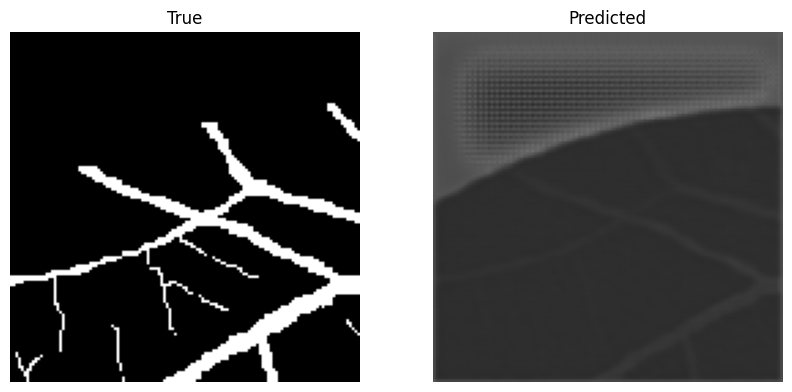


Jaccard: 0.06
Dice: 0.12


Epoch 10: val_loss did not improve from 0.30050
9/9 - 6s - loss: 0.2045 - accuracy: 0.9527 - val_loss: 0.3688 - val_accuracy: 0.9188 - 6s/epoch - 704ms/step
Epoch 11/150

Epoch 11: val_loss did not improve from 0.30050
9/9 - 4s - loss: 0.1970 - accuracy: 0.9522 - val_loss: 0.3538 - val_accuracy: 0.9188 - 4s/epoch - 413ms/step
Epoch 12/150

Epoch 12: val_loss did not improve from 0.30050
9/9 - 3s - loss: 0.1861 - accuracy: 0.9544 - val_loss: 0.3352 - val_accuracy: 0.9188 - 3s/epoch - 369ms/step
Epoch 13/150

Epoch 13: val_loss did not improve from 0.30050
9/9 - 5s - loss: 0.1791 - accuracy: 0.9544 - val_loss: 0.3214 - val_accuracy: 0.9188 - 5s/epoch - 565ms/step
Epoch 14/150

Epoch 14: val_loss did not improve from 0.30050
9/9 - 4s - loss: 0.1726 - accuracy: 0.9551 - val_loss: 0.3117 - val_accuracy: 0.9188 - 4s/epoch - 404ms/step
Epoch 15/150

Epoch 15: val_loss did not improve from 0.30050
9/9 - 3s - loss: 0.1701 - accuracy: 0.9545 - val_loss: 0.3013 - val_a

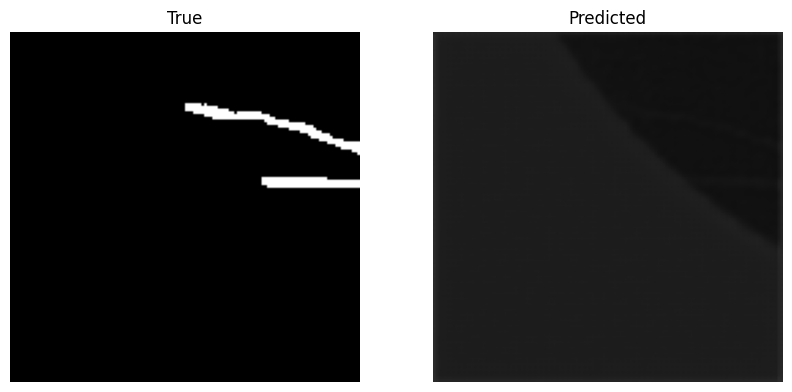


Jaccard: 0.04
Dice: 0.07


Epoch 19: val_loss improved from 0.28855 to 0.28791, saving model to Unet_DRIVE.h5
9/9 - 8s - loss: 0.1483 - accuracy: 0.9578 - val_loss: 0.2879 - val_accuracy: 0.9188 - 8s/epoch - 882ms/step
Epoch 20/150

Epoch 20: val_loss did not improve from 0.28791
9/9 - 4s - loss: 0.1449 - accuracy: 0.9585 - val_loss: 0.2888 - val_accuracy: 0.9188 - 4s/epoch - 407ms/step
Epoch 21/150

Epoch 21: val_loss improved from 0.28791 to 0.28673, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.1413 - accuracy: 0.9588 - val_loss: 0.2867 - val_accuracy: 0.9188 - 4s/epoch - 487ms/step
Epoch 22/150

Epoch 22: val_loss improved from 0.28673 to 0.28524, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.1360 - accuracy: 0.9599 - val_loss: 0.2852 - val_accuracy: 0.9188 - 4s/epoch - 473ms/step
Epoch 23/150

Epoch 23: val_loss improved from 0.28524 to 0.28403, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.1345 - accuracy: 0.9598 - val_loss: 0.2840 - val_accuracy: 0.9188 - 4s/epoch - 40

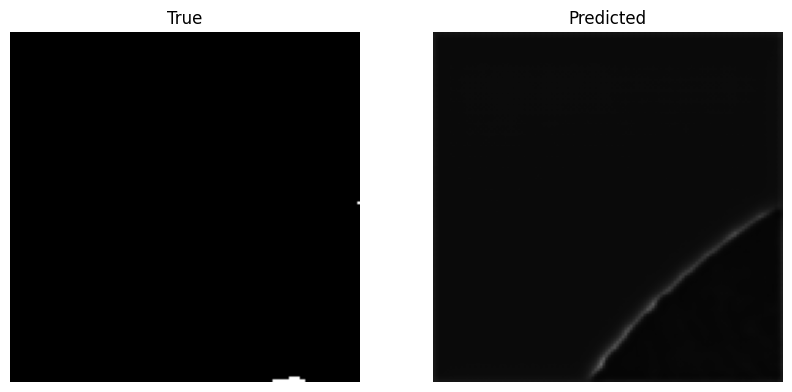


Jaccard: 0.03
Dice: 0.05


Epoch 28: val_loss did not improve from 0.28403
9/9 - 6s - loss: 0.1274 - accuracy: 0.9593 - val_loss: 0.3059 - val_accuracy: 0.9188 - 6s/epoch - 699ms/step
Epoch 29/150

Epoch 29: val_loss did not improve from 0.28403
9/9 - 3s - loss: 0.1257 - accuracy: 0.9599 - val_loss: 0.3015 - val_accuracy: 0.9187 - 3s/epoch - 386ms/step
Epoch 30/150

Epoch 30: val_loss did not improve from 0.28403
9/9 - 4s - loss: 0.1234 - accuracy: 0.9601 - val_loss: 0.2891 - val_accuracy: 0.9190 - 4s/epoch - 421ms/step
Epoch 31/150

Epoch 31: val_loss did not improve from 0.28403
9/9 - 3s - loss: 0.1215 - accuracy: 0.9604 - val_loss: 0.2869 - val_accuracy: 0.9187 - 3s/epoch - 371ms/step
Epoch 32/150

Epoch 32: val_loss did not improve from 0.28403
9/9 - 4s - loss: 0.1173 - accuracy: 0.9617 - val_loss: 0.2881 - val_accuracy: 0.9182 - 4s/epoch - 396ms/step
Epoch 33/150

Epoch 33: val_loss did not improve from 0.28403
9/9 - 4s - loss: 0.1156 - accuracy: 0.9621 - val_loss: 0.2889 - val_a

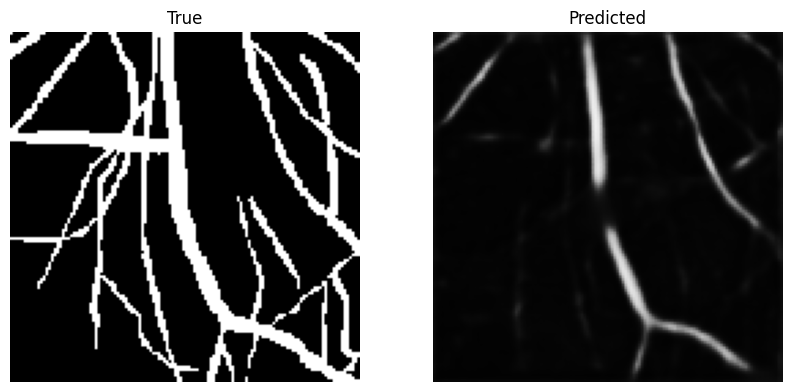


Jaccard: 0.09
Dice: 0.17


Epoch 37: val_loss improved from 0.26422 to 0.25996, saving model to Unet_DRIVE.h5
9/9 - 6s - loss: 0.1109 - accuracy: 0.9628 - val_loss: 0.2600 - val_accuracy: 0.9205 - 6s/epoch - 684ms/step
Epoch 38/150

Epoch 38: val_loss did not improve from 0.25996
9/9 - 4s - loss: 0.1087 - accuracy: 0.9632 - val_loss: 0.2610 - val_accuracy: 0.9202 - 4s/epoch - 461ms/step
Epoch 39/150

Epoch 39: val_loss improved from 0.25996 to 0.25197, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.1079 - accuracy: 0.9633 - val_loss: 0.2520 - val_accuracy: 0.9194 - 4s/epoch - 432ms/step
Epoch 40/150

Epoch 40: val_loss improved from 0.25197 to 0.23874, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.1069 - accuracy: 0.9635 - val_loss: 0.2387 - val_accuracy: 0.9207 - 4s/epoch - 445ms/step
Epoch 41/150

Epoch 41: val_loss improved from 0.23874 to 0.23594, saving model to Unet_DRIVE.h5
9/9 - 5s - loss: 0.1054 - accuracy: 0.9637 - val_loss: 0.2359 - val_accuracy: 0.9200 - 5s/epoch - 51

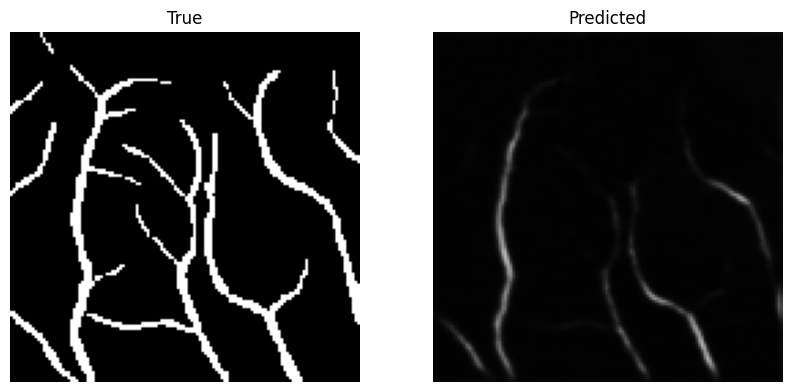


Jaccard: 0.20
Dice: 0.33


Epoch 46: val_loss did not improve from 0.20547
9/9 - 5s - loss: 0.1011 - accuracy: 0.9646 - val_loss: 0.2073 - val_accuracy: 0.9287 - 5s/epoch - 607ms/step
Epoch 47/150

Epoch 47: val_loss did not improve from 0.20547
9/9 - 4s - loss: 0.1001 - accuracy: 0.9650 - val_loss: 0.2077 - val_accuracy: 0.9307 - 4s/epoch - 411ms/step
Epoch 48/150

Epoch 48: val_loss improved from 0.20547 to 0.20497, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0999 - accuracy: 0.9650 - val_loss: 0.2050 - val_accuracy: 0.9295 - 4s/epoch - 440ms/step
Epoch 49/150

Epoch 49: val_loss improved from 0.20497 to 0.19432, saving model to Unet_DRIVE.h5
9/9 - 5s - loss: 0.0979 - accuracy: 0.9655 - val_loss: 0.1943 - val_accuracy: 0.9330 - 5s/epoch - 587ms/step
Epoch 50/150

Epoch 50: val_loss improved from 0.19432 to 0.17073, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0981 - accuracy: 0.9653 - val_loss: 0.1707 - val_accuracy: 0.9387 - 4s/epoch - 401ms/step
Epoch 51/150

Epoch 51: va

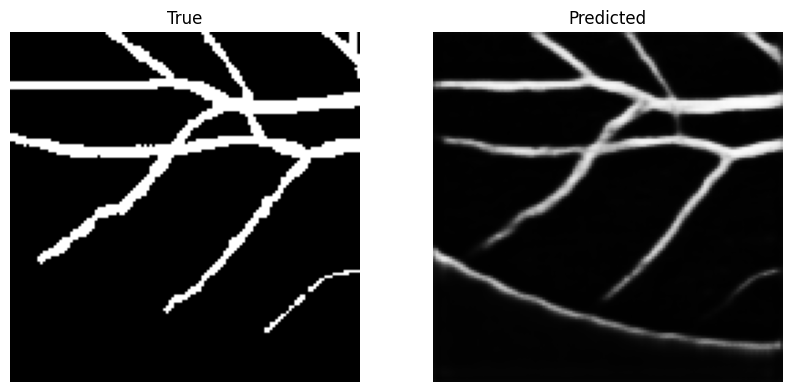


Jaccard: 0.35
Dice: 0.52


Epoch 55: val_loss improved from 0.16408 to 0.14918, saving model to Unet_DRIVE.h5
9/9 - 7s - loss: 0.0936 - accuracy: 0.9665 - val_loss: 0.1492 - val_accuracy: 0.9483 - 7s/epoch - 732ms/step
Epoch 56/150

Epoch 56: val_loss improved from 0.14918 to 0.14865, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0933 - accuracy: 0.9664 - val_loss: 0.1486 - val_accuracy: 0.9475 - 4s/epoch - 437ms/step
Epoch 57/150

Epoch 57: val_loss improved from 0.14865 to 0.14468, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0925 - accuracy: 0.9667 - val_loss: 0.1447 - val_accuracy: 0.9508 - 4s/epoch - 438ms/step
Epoch 58/150

Epoch 58: val_loss did not improve from 0.14468
9/9 - 4s - loss: 0.0932 - accuracy: 0.9664 - val_loss: 0.1454 - val_accuracy: 0.9522 - 4s/epoch - 464ms/step
Epoch 59/150

Epoch 59: val_loss improved from 0.14468 to 0.13575, saving model to Unet_DRIVE.h5
9/9 - 6s - loss: 0.0947 - accuracy: 0.9657 - val_loss: 0.1358 - val_accuracy: 0.9540 - 6s/epoch - 68

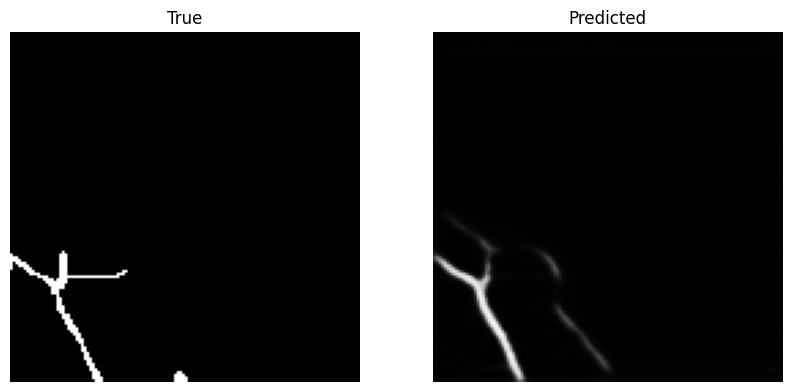


Jaccard: 0.41
Dice: 0.58


Epoch 64: val_loss improved from 0.10663 to 0.10597, saving model to Unet_DRIVE.h5
9/9 - 5s - loss: 0.0888 - accuracy: 0.9677 - val_loss: 0.1060 - val_accuracy: 0.9615 - 5s/epoch - 577ms/step
Epoch 65/150

Epoch 65: val_loss did not improve from 0.10597
9/9 - 3s - loss: 0.0871 - accuracy: 0.9680 - val_loss: 0.1075 - val_accuracy: 0.9623 - 3s/epoch - 369ms/step
Epoch 66/150

Epoch 66: val_loss improved from 0.10597 to 0.10172, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0875 - accuracy: 0.9677 - val_loss: 0.1017 - val_accuracy: 0.9646 - 4s/epoch - 439ms/step
Epoch 67/150

Epoch 67: val_loss did not improve from 0.10172
9/9 - 4s - loss: 0.0883 - accuracy: 0.9676 - val_loss: 0.1091 - val_accuracy: 0.9624 - 4s/epoch - 450ms/step
Epoch 68/150

Epoch 68: val_loss improved from 0.10172 to 0.09843, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0883 - accuracy: 0.9675 - val_loss: 0.0984 - val_accuracy: 0.9648 - 4s/epoch - 403ms/step
Epoch 69/150

Epoch 69: va

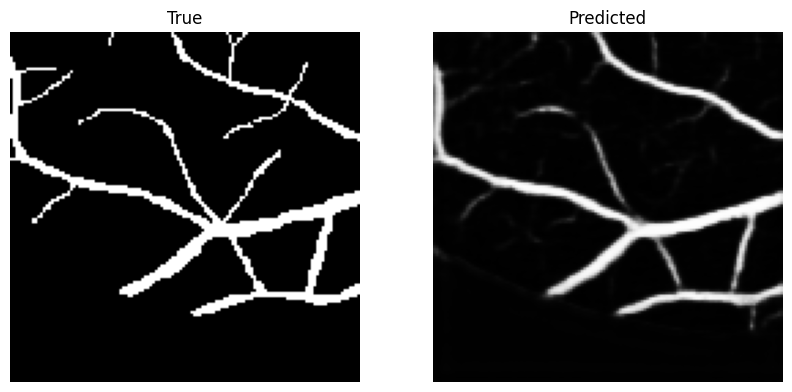


Jaccard: 0.48
Dice: 0.65


Epoch 73: val_loss did not improve from 0.08968
9/9 - 6s - loss: 0.0853 - accuracy: 0.9684 - val_loss: 0.0913 - val_accuracy: 0.9664 - 6s/epoch - 663ms/step
Epoch 74/150

Epoch 74: val_loss did not improve from 0.08968
9/9 - 4s - loss: 0.0853 - accuracy: 0.9682 - val_loss: 0.0913 - val_accuracy: 0.9664 - 4s/epoch - 491ms/step
Epoch 75/150

Epoch 75: val_loss improved from 0.08968 to 0.08559, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0840 - accuracy: 0.9688 - val_loss: 0.0856 - val_accuracy: 0.9678 - 4s/epoch - 436ms/step
Epoch 76/150

Epoch 76: val_loss did not improve from 0.08559
9/9 - 4s - loss: 0.0829 - accuracy: 0.9691 - val_loss: 0.0863 - val_accuracy: 0.9680 - 4s/epoch - 410ms/step
Epoch 77/150

Epoch 77: val_loss did not improve from 0.08559
9/9 - 4s - loss: 0.0835 - accuracy: 0.9687 - val_loss: 0.0857 - val_accuracy: 0.9681 - 4s/epoch - 413ms/step
Epoch 78/150

Epoch 78: val_loss did not improve from 0.08559
9/9 - 4s - loss: 0.0813 - accuracy

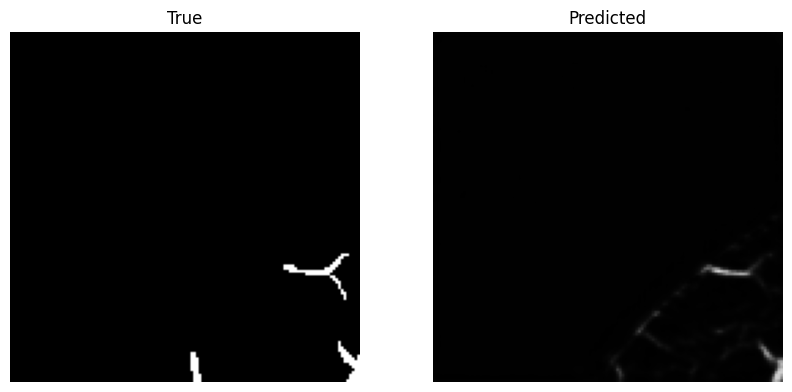


Jaccard: 0.56
Dice: 0.71


Epoch 82: val_loss improved from 0.08475 to 0.08417, saving model to Unet_DRIVE.h5
9/9 - 7s - loss: 0.0799 - accuracy: 0.9698 - val_loss: 0.0842 - val_accuracy: 0.9685 - 7s/epoch - 772ms/step
Epoch 83/150

Epoch 83: val_loss did not improve from 0.08417
9/9 - 3s - loss: 0.0791 - accuracy: 0.9700 - val_loss: 0.0865 - val_accuracy: 0.9676 - 3s/epoch - 375ms/step
Epoch 84/150

Epoch 84: val_loss did not improve from 0.08417
9/9 - 3s - loss: 0.0805 - accuracy: 0.9695 - val_loss: 0.0855 - val_accuracy: 0.9674 - 3s/epoch - 373ms/step
Epoch 85/150

Epoch 85: val_loss did not improve from 0.08417
9/9 - 4s - loss: 0.0796 - accuracy: 0.9697 - val_loss: 0.0849 - val_accuracy: 0.9678 - 4s/epoch - 468ms/step
Epoch 86/150

Epoch 86: val_loss did not improve from 0.08417
9/9 - 3s - loss: 0.0786 - accuracy: 0.9700 - val_loss: 0.0911 - val_accuracy: 0.9670 - 3s/epoch - 374ms/step
Epoch 87/150

Epoch 87: val_loss did not improve from 0.08417
9/9 - 3s - loss: 0.0774 - accuracy

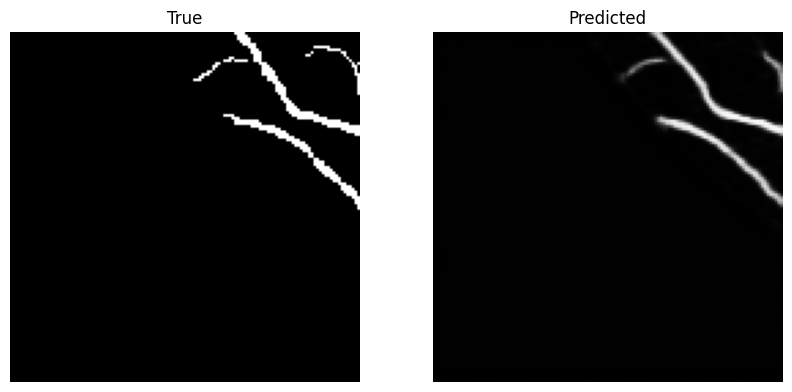


Jaccard: 0.56
Dice: 0.72


Epoch 91: val_loss did not improve from 0.08417
9/9 - 6s - loss: 0.0754 - accuracy: 0.9709 - val_loss: 0.0846 - val_accuracy: 0.9685 - 6s/epoch - 679ms/step
Epoch 92/150

Epoch 92: val_loss improved from 0.08417 to 0.08289, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0747 - accuracy: 0.9711 - val_loss: 0.0829 - val_accuracy: 0.9685 - 4s/epoch - 402ms/step
Epoch 93/150

Epoch 93: val_loss improved from 0.08289 to 0.08245, saving model to Unet_DRIVE.h5
9/9 - 4s - loss: 0.0728 - accuracy: 0.9718 - val_loss: 0.0824 - val_accuracy: 0.9689 - 4s/epoch - 408ms/step
Epoch 94/150

Epoch 94: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0718 - accuracy: 0.9719 - val_loss: 0.0879 - val_accuracy: 0.9678 - 4s/epoch - 473ms/step
Epoch 95/150

Epoch 95: val_loss did not improve from 0.08245
9/9 - 3s - loss: 0.0717 - accuracy: 0.9718 - val_loss: 0.0871 - val_accuracy: 0.9671 - 3s/epoch - 380ms/step
Epoch 96/150

Epoch 96: val_loss did not improve from 0.08245

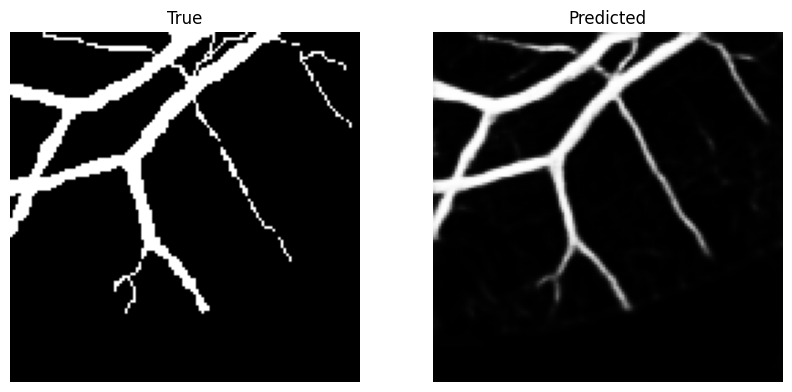


Jaccard: 0.59
Dice: 0.74


Epoch 100: val_loss did not improve from 0.08245
9/9 - 6s - loss: 0.0692 - accuracy: 0.9726 - val_loss: 0.0843 - val_accuracy: 0.9685 - 6s/epoch - 626ms/step
Epoch 101/150

Epoch 101: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0689 - accuracy: 0.9727 - val_loss: 0.0849 - val_accuracy: 0.9678 - 4s/epoch - 416ms/step
Epoch 102/150

Epoch 102: val_loss did not improve from 0.08245
9/9 - 3s - loss: 0.0692 - accuracy: 0.9725 - val_loss: 0.0862 - val_accuracy: 0.9679 - 3s/epoch - 372ms/step
Epoch 103/150

Epoch 103: val_loss did not improve from 0.08245
9/9 - 5s - loss: 0.0707 - accuracy: 0.9722 - val_loss: 0.0911 - val_accuracy: 0.9659 - 5s/epoch - 564ms/step
Epoch 104/150

Epoch 104: val_loss did not improve from 0.08245
9/9 - 3s - loss: 0.0713 - accuracy: 0.9721 - val_loss: 0.0981 - val_accuracy: 0.9636 - 3s/epoch - 374ms/step
Epoch 105/150

Epoch 105: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0694 - accuracy: 0.9725 - val_loss: 0.0

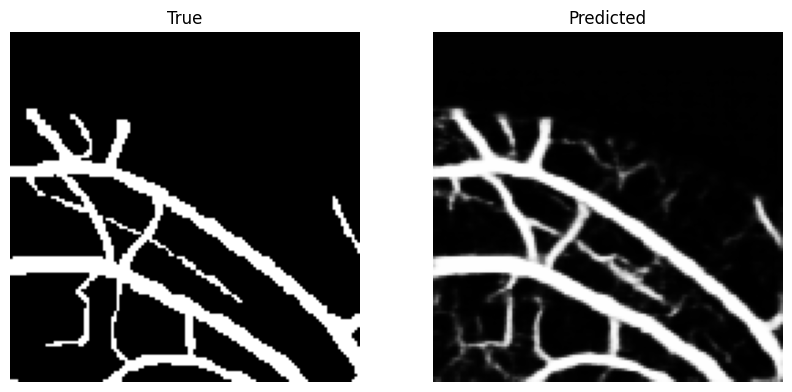


Jaccard: 0.64
Dice: 0.78


Epoch 109: val_loss did not improve from 0.08245
9/9 - 6s - loss: 0.0633 - accuracy: 0.9744 - val_loss: 0.0957 - val_accuracy: 0.9641 - 6s/epoch - 613ms/step
Epoch 110/150

Epoch 110: val_loss did not improve from 0.08245
9/9 - 3s - loss: 0.0628 - accuracy: 0.9747 - val_loss: 0.0916 - val_accuracy: 0.9651 - 3s/epoch - 380ms/step
Epoch 111/150

Epoch 111: val_loss did not improve from 0.08245
9/9 - 3s - loss: 0.0612 - accuracy: 0.9752 - val_loss: 0.1004 - val_accuracy: 0.9612 - 3s/epoch - 370ms/step
Epoch 112/150

Epoch 112: val_loss did not improve from 0.08245
9/9 - 5s - loss: 0.0639 - accuracy: 0.9742 - val_loss: 0.0904 - val_accuracy: 0.9655 - 5s/epoch - 561ms/step
Epoch 113/150

Epoch 113: val_loss did not improve from 0.08245
9/9 - 3s - loss: 0.0611 - accuracy: 0.9752 - val_loss: 0.0957 - val_accuracy: 0.9643 - 3s/epoch - 373ms/step
Epoch 114/150

Epoch 114: val_loss did not improve from 0.08245
9/9 - 3s - loss: 0.0588 - accuracy: 0.9762 - val_loss: 0.0

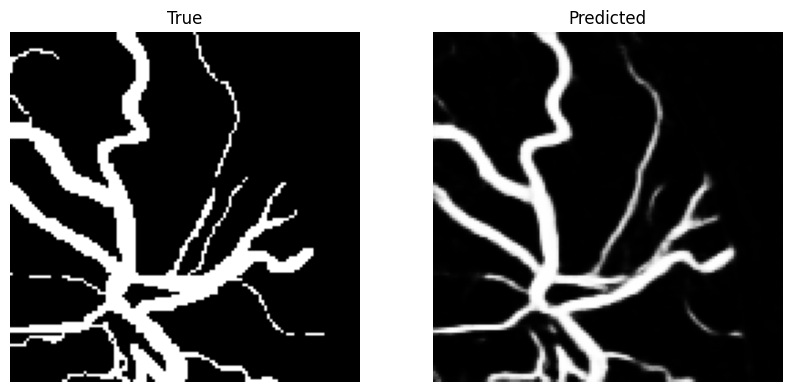


Jaccard: 0.63
Dice: 0.77


Epoch 118: val_loss did not improve from 0.08245
9/9 - 5s - loss: 0.0553 - accuracy: 0.9774 - val_loss: 0.0884 - val_accuracy: 0.9679 - 5s/epoch - 560ms/step
Epoch 119/150

Epoch 119: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0544 - accuracy: 0.9777 - val_loss: 0.0858 - val_accuracy: 0.9684 - 4s/epoch - 463ms/step
Epoch 120/150

Epoch 120: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0518 - accuracy: 0.9788 - val_loss: 0.0882 - val_accuracy: 0.9672 - 4s/epoch - 411ms/step
Epoch 121/150

Epoch 121: val_loss did not improve from 0.08245
9/9 - 3s - loss: 0.0511 - accuracy: 0.9792 - val_loss: 0.0878 - val_accuracy: 0.9674 - 3s/epoch - 379ms/step
Epoch 122/150

Epoch 122: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0512 - accuracy: 0.9790 - val_loss: 0.1007 - val_accuracy: 0.9627 - 4s/epoch - 468ms/step
Epoch 123/150

Epoch 123: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0524 - accuracy: 0.9785 - val_loss: 0.0

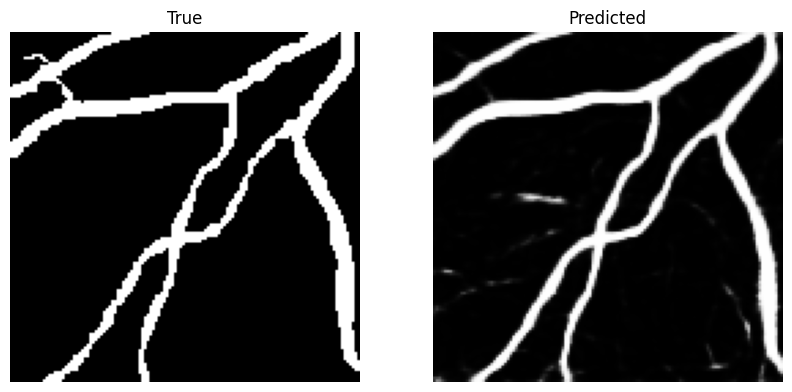


Jaccard: 0.67
Dice: 0.80


Epoch 127: val_loss did not improve from 0.08245
9/9 - 5s - loss: 0.0485 - accuracy: 0.9803 - val_loss: 0.0928 - val_accuracy: 0.9672 - 5s/epoch - 600ms/step
Epoch 128/150

Epoch 128: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0475 - accuracy: 0.9805 - val_loss: 0.0943 - val_accuracy: 0.9652 - 4s/epoch - 416ms/step
Epoch 129/150

Epoch 129: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0460 - accuracy: 0.9813 - val_loss: 0.1054 - val_accuracy: 0.9635 - 4s/epoch - 418ms/step
Epoch 130/150

Epoch 130: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0437 - accuracy: 0.9823 - val_loss: 0.0936 - val_accuracy: 0.9670 - 4s/epoch - 415ms/step
Epoch 131/150

Epoch 131: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0420 - accuracy: 0.9830 - val_loss: 0.0984 - val_accuracy: 0.9663 - 4s/epoch - 415ms/step
Epoch 132/150

Epoch 132: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0421 - accuracy: 0.9830 - val_loss: 0.0

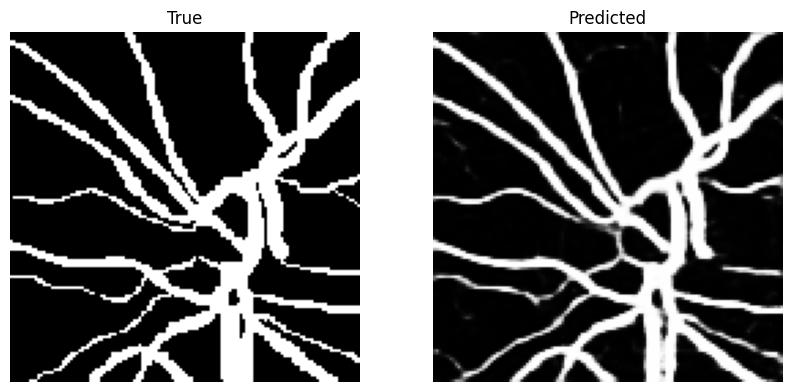


Jaccard: 0.72
Dice: 0.84


Epoch 136: val_loss did not improve from 0.08245
9/9 - 6s - loss: 0.0381 - accuracy: 0.9848 - val_loss: 0.0993 - val_accuracy: 0.9667 - 6s/epoch - 654ms/step
Epoch 137/150

Epoch 137: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0387 - accuracy: 0.9844 - val_loss: 0.1119 - val_accuracy: 0.9603 - 4s/epoch - 420ms/step
Epoch 138/150

Epoch 138: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0361 - accuracy: 0.9855 - val_loss: 0.1158 - val_accuracy: 0.9617 - 4s/epoch - 390ms/step
Epoch 139/150

Epoch 139: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0353 - accuracy: 0.9859 - val_loss: 0.1039 - val_accuracy: 0.9652 - 4s/epoch - 497ms/step
Epoch 140/150

Epoch 140: val_loss did not improve from 0.08245
9/9 - 3s - loss: 0.0335 - accuracy: 0.9866 - val_loss: 0.1077 - val_accuracy: 0.9643 - 3s/epoch - 386ms/step
Epoch 141/150

Epoch 141: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0345 - accuracy: 0.9862 - val_loss: 0.1

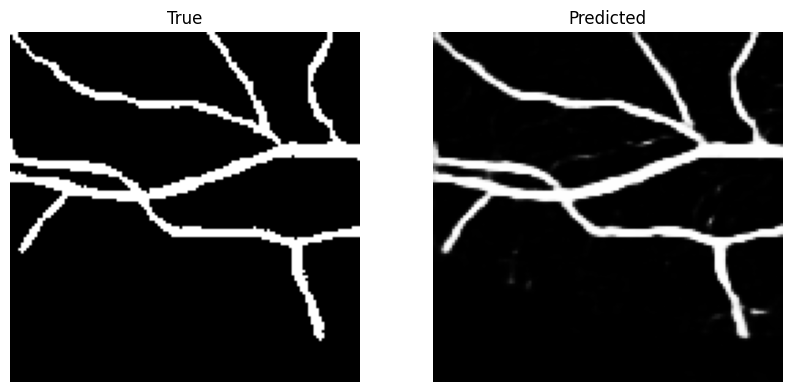


Jaccard: 0.72
Dice: 0.83


Epoch 145: val_loss did not improve from 0.08245
9/9 - 6s - loss: 0.0359 - accuracy: 0.9856 - val_loss: 0.1110 - val_accuracy: 0.9642 - 6s/epoch - 611ms/step
Epoch 146/150

Epoch 146: val_loss did not improve from 0.08245
9/9 - 5s - loss: 0.0343 - accuracy: 0.9862 - val_loss: 0.1120 - val_accuracy: 0.9641 - 5s/epoch - 559ms/step
Epoch 147/150

Epoch 147: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0316 - accuracy: 0.9875 - val_loss: 0.1140 - val_accuracy: 0.9635 - 4s/epoch - 423ms/step
Epoch 148/150

Epoch 148: val_loss did not improve from 0.08245
9/9 - 3s - loss: 0.0305 - accuracy: 0.9879 - val_loss: 0.1120 - val_accuracy: 0.9647 - 3s/epoch - 386ms/step
Epoch 149/150

Epoch 149: val_loss did not improve from 0.08245
9/9 - 5s - loss: 0.0283 - accuracy: 0.9889 - val_loss: 0.1167 - val_accuracy: 0.9647 - 5s/epoch - 564ms/step
Epoch 150/150

Epoch 150: val_loss did not improve from 0.08245
9/9 - 4s - loss: 0.0275 - accuracy: 0.9892 - val_loss: 0.1

In [110]:
history = model.fit(train, epochs=150, verbose=2,
                    callbacks=[CustomCallback(model, train), checkpointer],
                    validation_data=test)

## Evaluate and Plot Results

In [111]:
test_data = DatasetPreprocess(test_image_paths, test_label_paths, output_type='grayscale',
                              batch_size=32, resize_wh=512, num_crops=4,
                              split_dataset=False, is_test=True)

Output a 1 channel image. (grayscale)


In [112]:
test = test_data.get_dataset()

In [113]:
_ = model.evaluate(test)

20/20 [==============================] - 1s 52ms/step - loss: 0.0529 - accuracy: 0.9809


In [114]:
# Create an iterator
dataset_iterator = iter(test)

# Fetch one image-label pair
image, label = next(dataset_iterator)

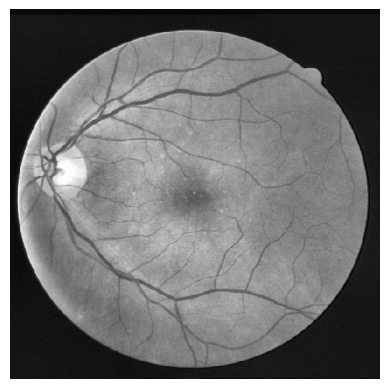

In [115]:
display_image(reconstruct_image(image.numpy()))

1/1 [==============================] - 0s 310ms/step


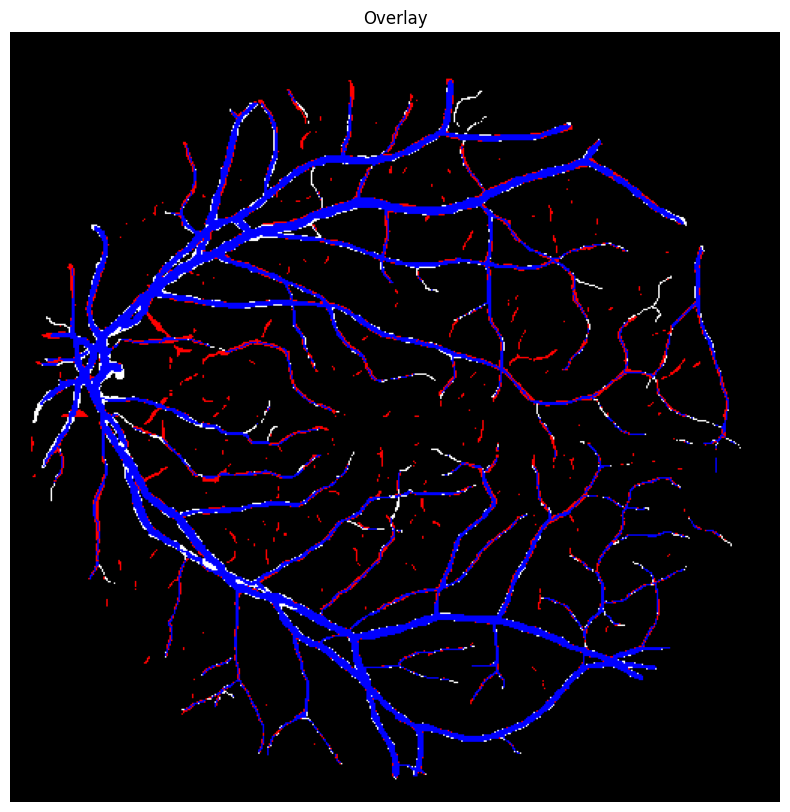

In [116]:
plot_segmentation_results(reconstruct_image(label.numpy()), reconstruct_image(model.predict(image)))

# MobilineNetV2 - Transfer Learning

## Preprocess and Display Images

In [117]:
data = DatasetPreprocess(image_paths, label_paths, output_type='color',
                         batch_size=32, resize_wh=512, num_crops=4,)
train, test = data.get_train_test()

Output a 3 channel image.


In [118]:
# Create an iterator
dataset_iterator = iter(train)

# Fetch one image-label pair
image, label = next(dataset_iterator)

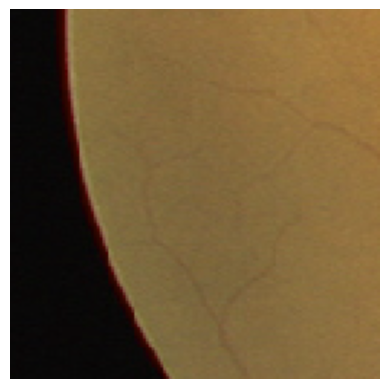

In [119]:
display_image(image[0, ...])

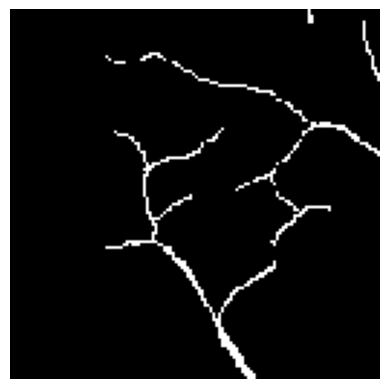

In [120]:
display_image(label[0, ...])

## Build and Compile

In [121]:
model = MV2Transfer(crop_wh, crop_wh, 1).build()

In [122]:
model.compile(optimizer='adam', loss=combined_loss,
              metrics=['accuracy'])

In [123]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_5 (Functional)        [(None, 64, 64, 96),         1841984   ['input_12[0][0]']            
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

## Train

In [124]:
save_path = 'MV2net_transfer_DRIVE.h5'
save_best_only = True

In [125]:
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

Epoch 1/150
1/1 [==============================] - 1s 820ms/step


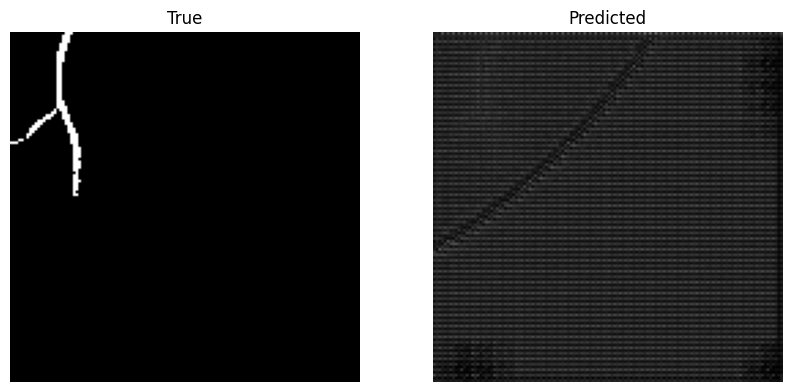


Jaccard: 0.06
Dice: 0.11


Epoch 1: val_loss improved from inf to 0.59231, saving model to MV2net_transfer_DRIVE.h5


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


9/9 - 11s - loss: 0.8118 - accuracy: 0.7528 - val_loss: 0.5923 - val_accuracy: 0.9188 - 11s/epoch - 1s/step
Epoch 2/150

Epoch 2: val_loss improved from 0.59231 to 0.55203, saving model to MV2net_transfer_DRIVE.h5
9/9 - 4s - loss: 0.5648 - accuracy: 0.9128 - val_loss: 0.5520 - val_accuracy: 0.9188 - 4s/epoch - 427ms/step
Epoch 3/150

Epoch 3: val_loss improved from 0.55203 to 0.51858, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.5218 - accuracy: 0.9130 - val_loss: 0.5186 - val_accuracy: 0.9188 - 3s/epoch - 371ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.51858 to 0.47800, saving model to MV2net_transfer_DRIVE.h5
9/9 - 4s - loss: 0.4616 - accuracy: 0.9211 - val_loss: 0.4780 - val_accuracy: 0.9209 - 4s/epoch - 441ms/step
Epoch 5/150

Epoch 5: val_loss improved from 0.47800 to 0.46043, saving model to MV2net_transfer_DRIVE.h5
9/9 - 4s - loss: 0.4128 - accuracy: 0.9323 - val_loss: 0.4604 - val_accuracy: 0.9213 - 4s/epoch - 434ms/step
Epoch 6/150

Epoch 6: val_loss i

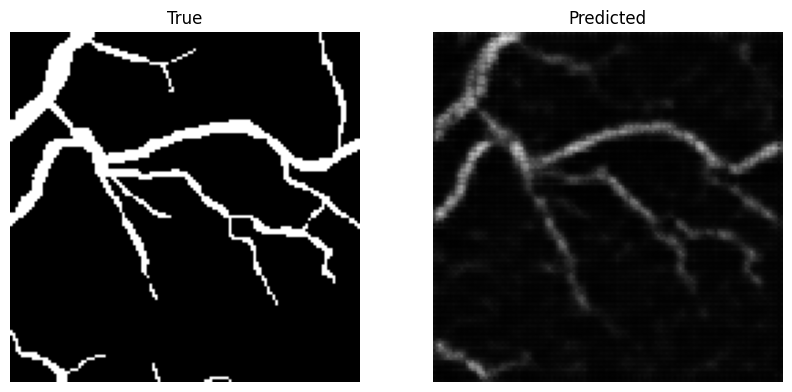


Jaccard: 0.17
Dice: 0.29


Epoch 10: val_loss did not improve from 0.40363
9/9 - 4s - loss: 0.3024 - accuracy: 0.9531 - val_loss: 0.4047 - val_accuracy: 0.9284 - 4s/epoch - 480ms/step
Epoch 11/150

Epoch 11: val_loss improved from 0.40363 to 0.39945, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.2926 - accuracy: 0.9545 - val_loss: 0.3994 - val_accuracy: 0.9296 - 3s/epoch - 377ms/step
Epoch 12/150

Epoch 12: val_loss improved from 0.39945 to 0.38984, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.2863 - accuracy: 0.9553 - val_loss: 0.3898 - val_accuracy: 0.9322 - 3s/epoch - 380ms/step
Epoch 13/150

Epoch 13: val_loss improved from 0.38984 to 0.37236, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.2794 - accuracy: 0.9565 - val_loss: 0.3724 - val_accuracy: 0.9369 - 3s/epoch - 383ms/step
Epoch 14/150

Epoch 14: val_loss improved from 0.37236 to 0.36667, saving model to MV2net_transfer_DRIVE.h5
9/9 - 4s - loss: 0.2751 - accuracy: 0.9569 - val_loss: 0

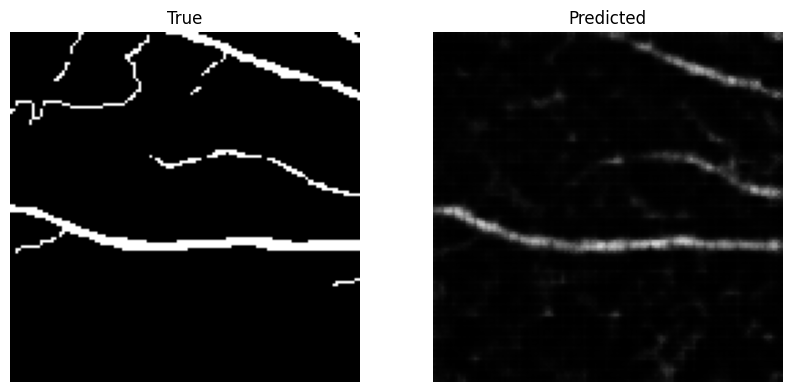


Jaccard: 0.35
Dice: 0.52


Epoch 19: val_loss improved from 0.35161 to 0.33808, saving model to MV2net_transfer_DRIVE.h5
9/9 - 4s - loss: 0.2557 - accuracy: 0.9603 - val_loss: 0.3381 - val_accuracy: 0.9465 - 4s/epoch - 456ms/step
Epoch 20/150

Epoch 20: val_loss improved from 0.33808 to 0.32432, saving model to MV2net_transfer_DRIVE.h5
9/9 - 4s - loss: 0.2527 - accuracy: 0.9610 - val_loss: 0.3243 - val_accuracy: 0.9502 - 4s/epoch - 458ms/step
Epoch 21/150

Epoch 21: val_loss improved from 0.32432 to 0.30777, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.2490 - accuracy: 0.9619 - val_loss: 0.3078 - val_accuracy: 0.9540 - 3s/epoch - 311ms/step
Epoch 22/150

Epoch 22: val_loss improved from 0.30777 to 0.29150, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.2461 - accuracy: 0.9619 - val_loss: 0.2915 - val_accuracy: 0.9575 - 3s/epoch - 316ms/step
Epoch 23/150

Epoch 23: val_loss improved from 0.29150 to 0.28807, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s -

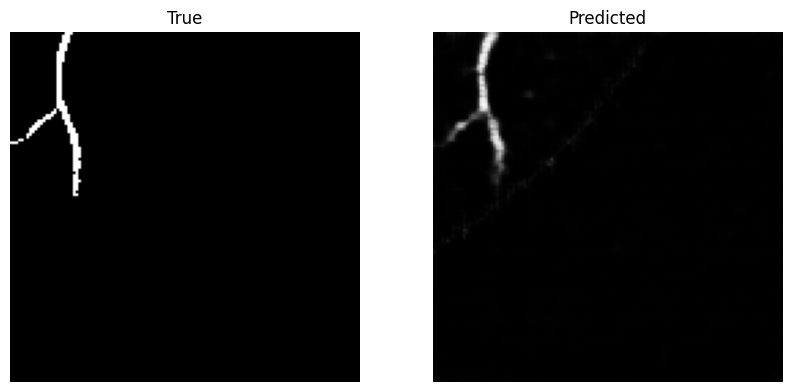


Jaccard: 0.53
Dice: 0.69


Epoch 28: val_loss improved from 0.27834 to 0.26937, saving model to MV2net_transfer_DRIVE.h5
9/9 - 4s - loss: 0.2220 - accuracy: 0.9661 - val_loss: 0.2694 - val_accuracy: 0.9591 - 4s/epoch - 497ms/step
Epoch 29/150

Epoch 29: val_loss improved from 0.26937 to 0.26446, saving model to MV2net_transfer_DRIVE.h5
9/9 - 3s - loss: 0.2183 - accuracy: 0.9671 - val_loss: 0.2645 - val_accuracy: 0.9592 - 3s/epoch - 311ms/step
Epoch 30/150

Epoch 30: val_loss did not improve from 0.26446
9/9 - 4s - loss: 0.2225 - accuracy: 0.9659 - val_loss: 0.2683 - val_accuracy: 0.9585 - 4s/epoch - 459ms/step
Epoch 31/150

Epoch 31: val_loss did not improve from 0.26446
9/9 - 3s - loss: 0.2144 - accuracy: 0.9678 - val_loss: 0.2657 - val_accuracy: 0.9590 - 3s/epoch - 326ms/step
Epoch 32/150

Epoch 32: val_loss did not improve from 0.26446
9/9 - 3s - loss: 0.2086 - accuracy: 0.9683 - val_loss: 0.2672 - val_accuracy: 0.9593 - 3s/epoch - 317ms/step
Epoch 33/150

Epoch 33: val_loss improv

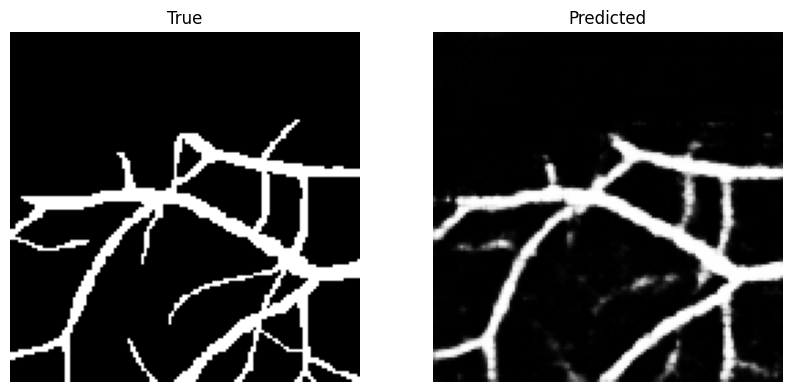


Jaccard: 0.60
Dice: 0.75


Epoch 37: val_loss did not improve from 0.26281
9/9 - 6s - loss: 0.1986 - accuracy: 0.9701 - val_loss: 0.2708 - val_accuracy: 0.9570 - 6s/epoch - 642ms/step
Epoch 38/150

Epoch 38: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1910 - accuracy: 0.9716 - val_loss: 0.2700 - val_accuracy: 0.9578 - 3s/epoch - 317ms/step
Epoch 39/150

Epoch 39: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.1852 - accuracy: 0.9725 - val_loss: 0.2702 - val_accuracy: 0.9588 - 2s/epoch - 265ms/step
Epoch 40/150

Epoch 40: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1799 - accuracy: 0.9735 - val_loss: 0.2717 - val_accuracy: 0.9575 - 3s/epoch - 314ms/step
Epoch 41/150

Epoch 41: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1755 - accuracy: 0.9742 - val_loss: 0.2722 - val_accuracy: 0.9577 - 3s/epoch - 379ms/step
Epoch 42/150

Epoch 42: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1714 - accuracy: 0.9748 - val_loss: 0.2751 - val_a

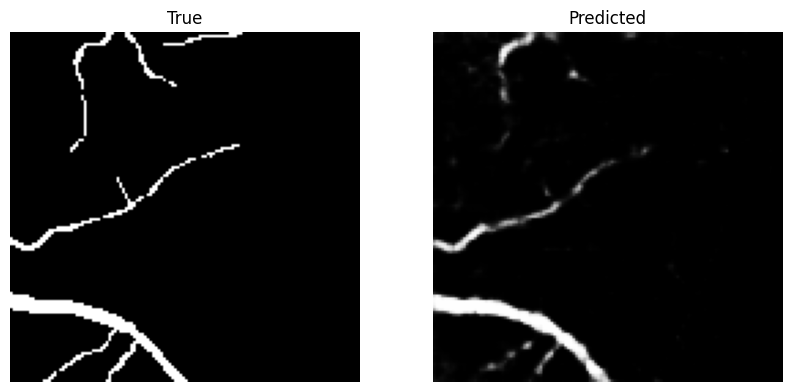


Jaccard: 0.69
Dice: 0.82


Epoch 46: val_loss did not improve from 0.26281
9/9 - 5s - loss: 0.1603 - accuracy: 0.9767 - val_loss: 0.2798 - val_accuracy: 0.9579 - 5s/epoch - 606ms/step
Epoch 47/150

Epoch 47: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.1592 - accuracy: 0.9769 - val_loss: 0.2872 - val_accuracy: 0.9562 - 2s/epoch - 272ms/step
Epoch 48/150

Epoch 48: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1547 - accuracy: 0.9776 - val_loss: 0.2905 - val_accuracy: 0.9580 - 3s/epoch - 318ms/step
Epoch 49/150

Epoch 49: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1506 - accuracy: 0.9784 - val_loss: 0.2901 - val_accuracy: 0.9578 - 3s/epoch - 344ms/step
Epoch 50/150

Epoch 50: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1481 - accuracy: 0.9787 - val_loss: 0.2920 - val_accuracy: 0.9575 - 3s/epoch - 316ms/step
Epoch 51/150

Epoch 51: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.1422 - accuracy: 0.9798 - val_loss: 0.2934 - val_a

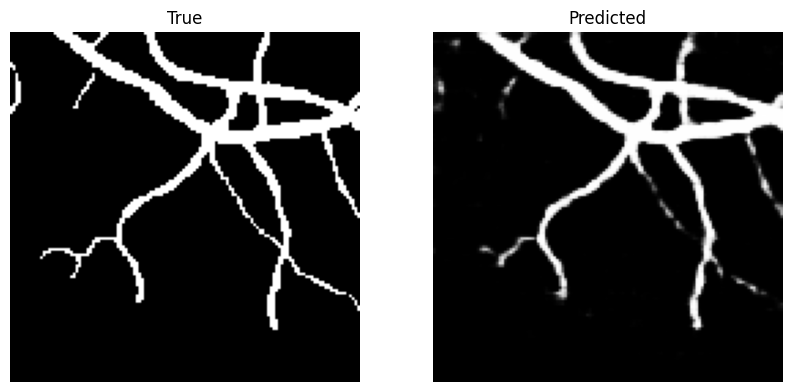


Jaccard: 0.72
Dice: 0.83


Epoch 55: val_loss did not improve from 0.26281
9/9 - 4s - loss: 0.1337 - accuracy: 0.9813 - val_loss: 0.3029 - val_accuracy: 0.9561 - 4s/epoch - 415ms/step
Epoch 56/150

Epoch 56: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1332 - accuracy: 0.9812 - val_loss: 0.3088 - val_accuracy: 0.9547 - 3s/epoch - 319ms/step
Epoch 57/150

Epoch 57: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1277 - accuracy: 0.9821 - val_loss: 0.3069 - val_accuracy: 0.9550 - 3s/epoch - 320ms/step
Epoch 58/150

Epoch 58: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.1259 - accuracy: 0.9821 - val_loss: 0.3080 - val_accuracy: 0.9557 - 2s/epoch - 270ms/step
Epoch 59/150

Epoch 59: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.1315 - accuracy: 0.9811 - val_loss: 0.3074 - val_accuracy: 0.9551 - 2s/epoch - 277ms/step
Epoch 60/150

Epoch 60: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1283 - accuracy: 0.9817 - val_loss: 0.3159 - val_a

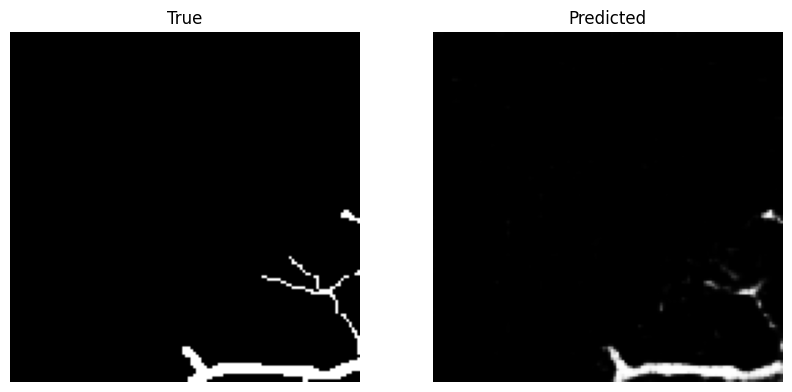


Jaccard: 0.78
Dice: 0.88


Epoch 64: val_loss did not improve from 0.26281
9/9 - 6s - loss: 0.1106 - accuracy: 0.9846 - val_loss: 0.3245 - val_accuracy: 0.9560 - 6s/epoch - 611ms/step
Epoch 65/150

Epoch 65: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1067 - accuracy: 0.9853 - val_loss: 0.3249 - val_accuracy: 0.9550 - 3s/epoch - 315ms/step
Epoch 66/150

Epoch 66: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1077 - accuracy: 0.9851 - val_loss: 0.3254 - val_accuracy: 0.9547 - 3s/epoch - 366ms/step
Epoch 67/150

Epoch 67: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1075 - accuracy: 0.9851 - val_loss: 0.3424 - val_accuracy: 0.9561 - 3s/epoch - 318ms/step
Epoch 68/150

Epoch 68: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1140 - accuracy: 0.9838 - val_loss: 0.3279 - val_accuracy: 0.9540 - 3s/epoch - 351ms/step
Epoch 69/150

Epoch 69: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.1066 - accuracy: 0.9853 - val_loss: 0.3368 - val_a

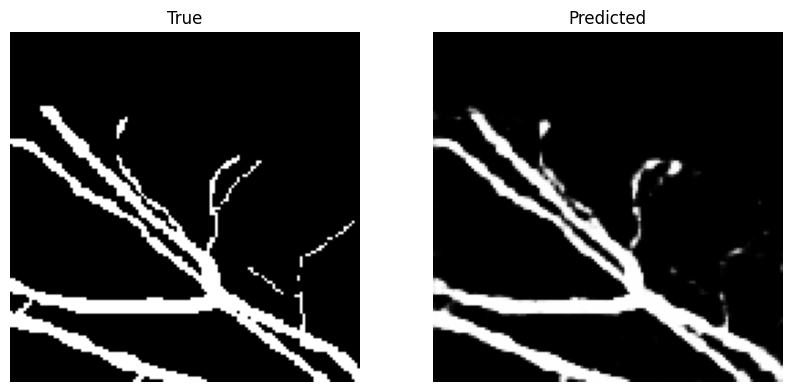


Jaccard: 0.80
Dice: 0.89


Epoch 73: val_loss did not improve from 0.26281
9/9 - 4s - loss: 0.0964 - accuracy: 0.9866 - val_loss: 0.3456 - val_accuracy: 0.9538 - 4s/epoch - 418ms/step
Epoch 74/150

Epoch 74: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0971 - accuracy: 0.9865 - val_loss: 0.3435 - val_accuracy: 0.9533 - 2s/epoch - 264ms/step
Epoch 75/150

Epoch 75: val_loss did not improve from 0.26281
9/9 - 4s - loss: 0.0982 - accuracy: 0.9863 - val_loss: 0.3493 - val_accuracy: 0.9523 - 4s/epoch - 463ms/step
Epoch 76/150

Epoch 76: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0935 - accuracy: 0.9871 - val_loss: 0.3525 - val_accuracy: 0.9543 - 2s/epoch - 274ms/step
Epoch 77/150

Epoch 77: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0904 - accuracy: 0.9875 - val_loss: 0.3517 - val_accuracy: 0.9531 - 3s/epoch - 315ms/step
Epoch 78/150

Epoch 78: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0883 - accuracy: 0.9879 - val_loss: 0.3530 - val_a

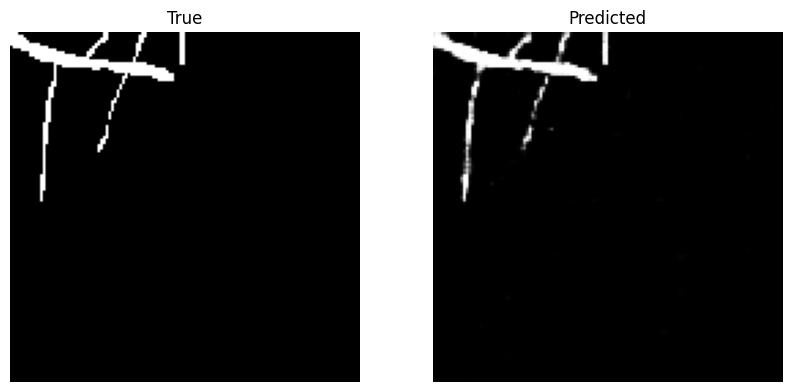


Jaccard: 0.85
Dice: 0.92


Epoch 82: val_loss did not improve from 0.26281
9/9 - 6s - loss: 0.0829 - accuracy: 0.9886 - val_loss: 0.3653 - val_accuracy: 0.9535 - 6s/epoch - 613ms/step
Epoch 83/150

Epoch 83: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0812 - accuracy: 0.9891 - val_loss: 0.3645 - val_accuracy: 0.9532 - 2s/epoch - 271ms/step
Epoch 84/150

Epoch 84: val_loss did not improve from 0.26281
9/9 - 4s - loss: 0.0786 - accuracy: 0.9895 - val_loss: 0.3671 - val_accuracy: 0.9532 - 4s/epoch - 467ms/step
Epoch 85/150

Epoch 85: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0789 - accuracy: 0.9893 - val_loss: 0.3730 - val_accuracy: 0.9514 - 2s/epoch - 264ms/step
Epoch 86/150

Epoch 86: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0829 - accuracy: 0.9886 - val_loss: 0.3795 - val_accuracy: 0.9538 - 3s/epoch - 319ms/step
Epoch 87/150

Epoch 87: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0838 - accuracy: 0.9883 - val_loss: 0.3773 - val_a

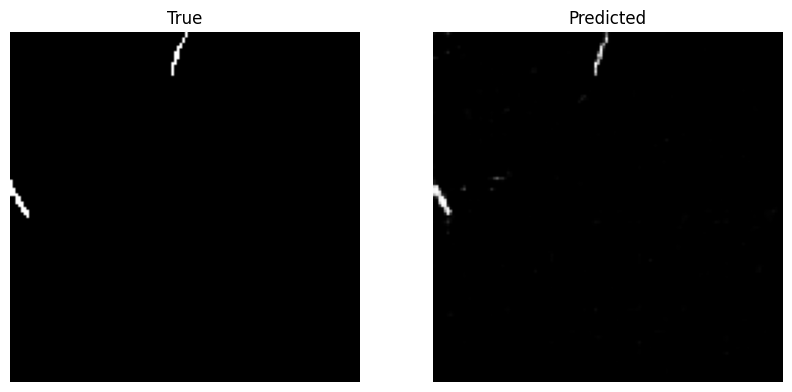


Jaccard: 0.84
Dice: 0.91


Epoch 91: val_loss did not improve from 0.26281
9/9 - 5s - loss: 0.0742 - accuracy: 0.9901 - val_loss: 0.3820 - val_accuracy: 0.9520 - 5s/epoch - 607ms/step
Epoch 92/150

Epoch 92: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0752 - accuracy: 0.9897 - val_loss: 0.3811 - val_accuracy: 0.9531 - 2s/epoch - 273ms/step
Epoch 93/150

Epoch 93: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0737 - accuracy: 0.9903 - val_loss: 0.3820 - val_accuracy: 0.9516 - 3s/epoch - 315ms/step
Epoch 94/150

Epoch 94: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0681 - accuracy: 0.9911 - val_loss: 0.3926 - val_accuracy: 0.9540 - 3s/epoch - 345ms/step
Epoch 95/150

Epoch 95: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0673 - accuracy: 0.9912 - val_loss: 0.3917 - val_accuracy: 0.9515 - 3s/epoch - 364ms/step
Epoch 96/150

Epoch 96: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0663 - accuracy: 0.9913 - val_loss: 0.3912 - val_a

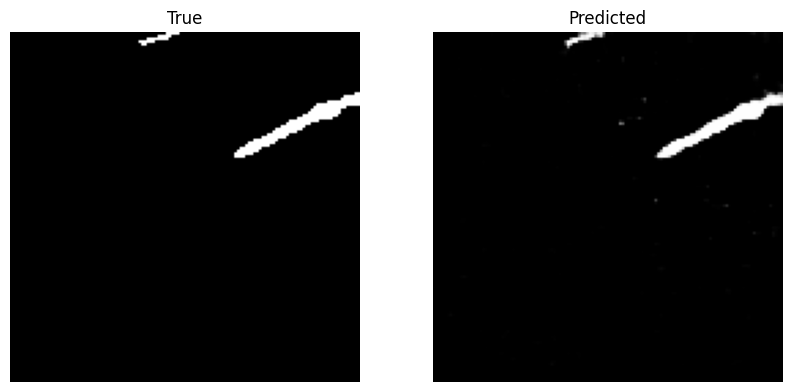


Jaccard: 0.89
Dice: 0.94


Epoch 100: val_loss did not improve from 0.26281
9/9 - 5s - loss: 0.0598 - accuracy: 0.9923 - val_loss: 0.4011 - val_accuracy: 0.9524 - 5s/epoch - 533ms/step
Epoch 101/150

Epoch 101: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0622 - accuracy: 0.9918 - val_loss: 0.4049 - val_accuracy: 0.9520 - 3s/epoch - 337ms/step
Epoch 102/150

Epoch 102: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0589 - accuracy: 0.9924 - val_loss: 0.4081 - val_accuracy: 0.9521 - 2s/epoch - 262ms/step
Epoch 103/150

Epoch 103: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0587 - accuracy: 0.9924 - val_loss: 0.4078 - val_accuracy: 0.9525 - 2s/epoch - 265ms/step
Epoch 104/150

Epoch 104: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0553 - accuracy: 0.9930 - val_loss: 0.4075 - val_accuracy: 0.9530 - 2s/epoch - 267ms/step
Epoch 105/150

Epoch 105: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0548 - accuracy: 0.9932 - val_loss: 0.4

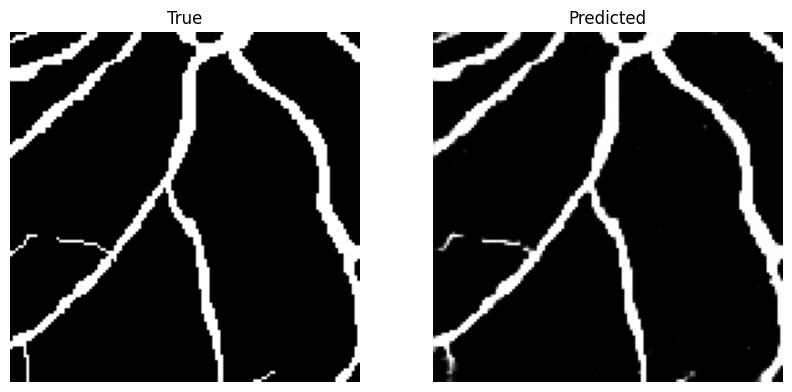


Jaccard: 0.90
Dice: 0.95


Epoch 109: val_loss did not improve from 0.26281
9/9 - 6s - loss: 0.0533 - accuracy: 0.9933 - val_loss: 0.4265 - val_accuracy: 0.9520 - 6s/epoch - 674ms/step
Epoch 110/150

Epoch 110: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0526 - accuracy: 0.9935 - val_loss: 0.4236 - val_accuracy: 0.9520 - 2s/epoch - 265ms/step
Epoch 111/150

Epoch 111: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0515 - accuracy: 0.9936 - val_loss: 0.4286 - val_accuracy: 0.9505 - 3s/epoch - 314ms/step
Epoch 112/150

Epoch 112: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0487 - accuracy: 0.9940 - val_loss: 0.4297 - val_accuracy: 0.9527 - 2s/epoch - 272ms/step
Epoch 113/150

Epoch 113: val_loss did not improve from 0.26281
9/9 - 4s - loss: 0.0467 - accuracy: 0.9944 - val_loss: 0.4299 - val_accuracy: 0.9527 - 4s/epoch - 391ms/step
Epoch 114/150

Epoch 114: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0486 - accuracy: 0.9940 - val_loss: 0.4

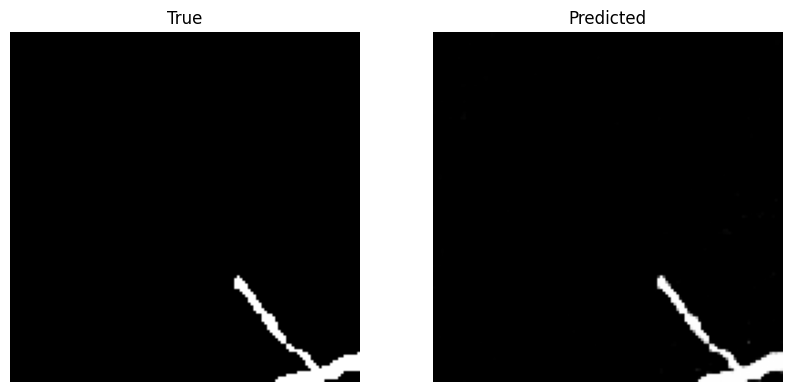


Jaccard: 0.90
Dice: 0.95


Epoch 118: val_loss did not improve from 0.26281
9/9 - 4s - loss: 0.0450 - accuracy: 0.9945 - val_loss: 0.4383 - val_accuracy: 0.9517 - 4s/epoch - 458ms/step
Epoch 119/150

Epoch 119: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0454 - accuracy: 0.9944 - val_loss: 0.4425 - val_accuracy: 0.9528 - 3s/epoch - 345ms/step
Epoch 120/150

Epoch 120: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0456 - accuracy: 0.9943 - val_loss: 0.4409 - val_accuracy: 0.9519 - 2s/epoch - 271ms/step
Epoch 121/150

Epoch 121: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0478 - accuracy: 0.9939 - val_loss: 0.4418 - val_accuracy: 0.9514 - 2s/epoch - 266ms/step
Epoch 122/150

Epoch 122: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0454 - accuracy: 0.9944 - val_loss: 0.4501 - val_accuracy: 0.9520 - 3s/epoch - 314ms/step
Epoch 123/150

Epoch 123: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0456 - accuracy: 0.9942 - val_loss: 0.4

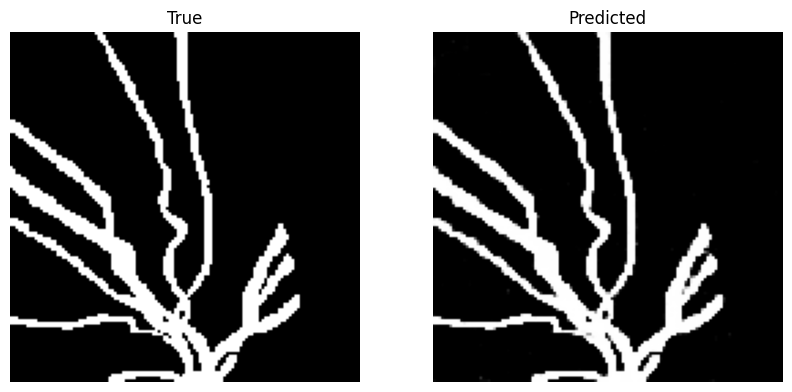


Jaccard: 0.93
Dice: 0.96


Epoch 127: val_loss did not improve from 0.26281
9/9 - 5s - loss: 0.0380 - accuracy: 0.9956 - val_loss: 0.4553 - val_accuracy: 0.9513 - 5s/epoch - 601ms/step
Epoch 128/150

Epoch 128: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0376 - accuracy: 0.9956 - val_loss: 0.4526 - val_accuracy: 0.9511 - 3s/epoch - 316ms/step
Epoch 129/150

Epoch 129: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0346 - accuracy: 0.9961 - val_loss: 0.4614 - val_accuracy: 0.9515 - 3s/epoch - 291ms/step
Epoch 130/150

Epoch 130: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0370 - accuracy: 0.9957 - val_loss: 0.4610 - val_accuracy: 0.9516 - 3s/epoch - 315ms/step
Epoch 131/150

Epoch 131: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0375 - accuracy: 0.9956 - val_loss: 0.4617 - val_accuracy: 0.9514 - 2s/epoch - 276ms/step
Epoch 132/150

Epoch 132: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0390 - accuracy: 0.9953 - val_loss: 0.4

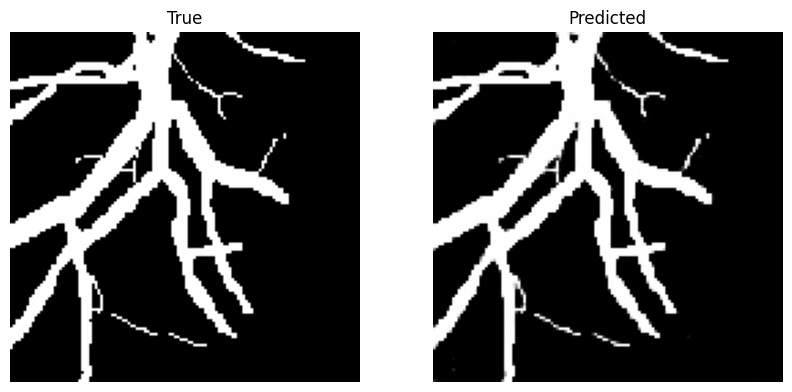


Jaccard: 0.93
Dice: 0.97


Epoch 136: val_loss did not improve from 0.26281
9/9 - 9s - loss: 0.0332 - accuracy: 0.9962 - val_loss: 0.4750 - val_accuracy: 0.9515 - 9s/epoch - 961ms/step
Epoch 137/150

Epoch 137: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0315 - accuracy: 0.9965 - val_loss: 0.4731 - val_accuracy: 0.9516 - 2s/epoch - 268ms/step
Epoch 138/150

Epoch 138: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0313 - accuracy: 0.9965 - val_loss: 0.4786 - val_accuracy: 0.9522 - 2s/epoch - 272ms/step
Epoch 139/150

Epoch 139: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0290 - accuracy: 0.9969 - val_loss: 0.4812 - val_accuracy: 0.9518 - 3s/epoch - 319ms/step
Epoch 140/150

Epoch 140: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0314 - accuracy: 0.9964 - val_loss: 0.4770 - val_accuracy: 0.9513 - 3s/epoch - 364ms/step
Epoch 141/150

Epoch 141: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0312 - accuracy: 0.9965 - val_loss: 0.4

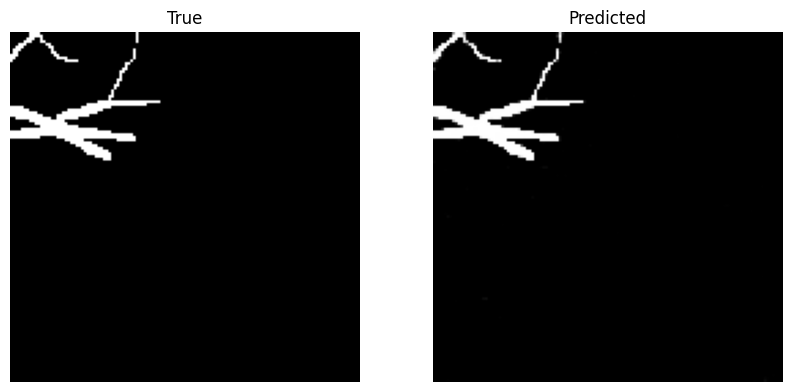


Jaccard: 0.95
Dice: 0.98


Epoch 145: val_loss did not improve from 0.26281
9/9 - 4s - loss: 0.0273 - accuracy: 0.9971 - val_loss: 0.4849 - val_accuracy: 0.9512 - 4s/epoch - 499ms/step
Epoch 146/150

Epoch 146: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0282 - accuracy: 0.9969 - val_loss: 0.4950 - val_accuracy: 0.9522 - 2s/epoch - 271ms/step
Epoch 147/150

Epoch 147: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0290 - accuracy: 0.9967 - val_loss: 0.4837 - val_accuracy: 0.9518 - 3s/epoch - 319ms/step
Epoch 148/150

Epoch 148: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0272 - accuracy: 0.9970 - val_loss: 0.4911 - val_accuracy: 0.9516 - 3s/epoch - 369ms/step
Epoch 149/150

Epoch 149: val_loss did not improve from 0.26281
9/9 - 2s - loss: 0.0256 - accuracy: 0.9973 - val_loss: 0.5005 - val_accuracy: 0.9514 - 2s/epoch - 271ms/step
Epoch 150/150

Epoch 150: val_loss did not improve from 0.26281
9/9 - 3s - loss: 0.0251 - accuracy: 0.9973 - val_loss: 0.4

In [126]:
history = model.fit(train, epochs=150, verbose=2,
                    callbacks=[CustomCallback(model, train), checkpointer],
                    validation_data=test)

## Evaluate and Plot Results

In [127]:
test_data = DatasetPreprocess(test_image_paths, test_label_paths, output_type='color',
                              batch_size=32, resize_wh=512, num_crops=4,
                              split_dataset=False, is_test=True)

Output a 3 channel image.


In [128]:
test = test_data.get_dataset()

In [129]:
_ = model.evaluate(test)

20/20 [==============================] - 1s 54ms/step - loss: 0.0895 - accuracy: 0.9914


In [130]:
# Create an iterator
dataset_iterator = iter(test)

# Fetch one image-label pair
image, label = next(dataset_iterator)

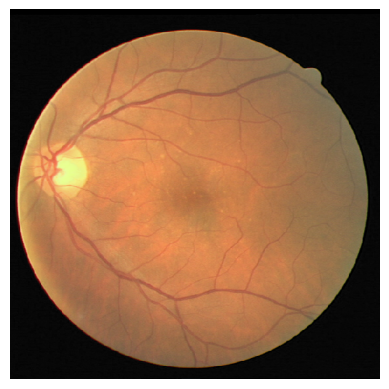

In [131]:
display_image(reconstruct_image(image.numpy()))

1/1 [==============================] - 1s 855ms/step


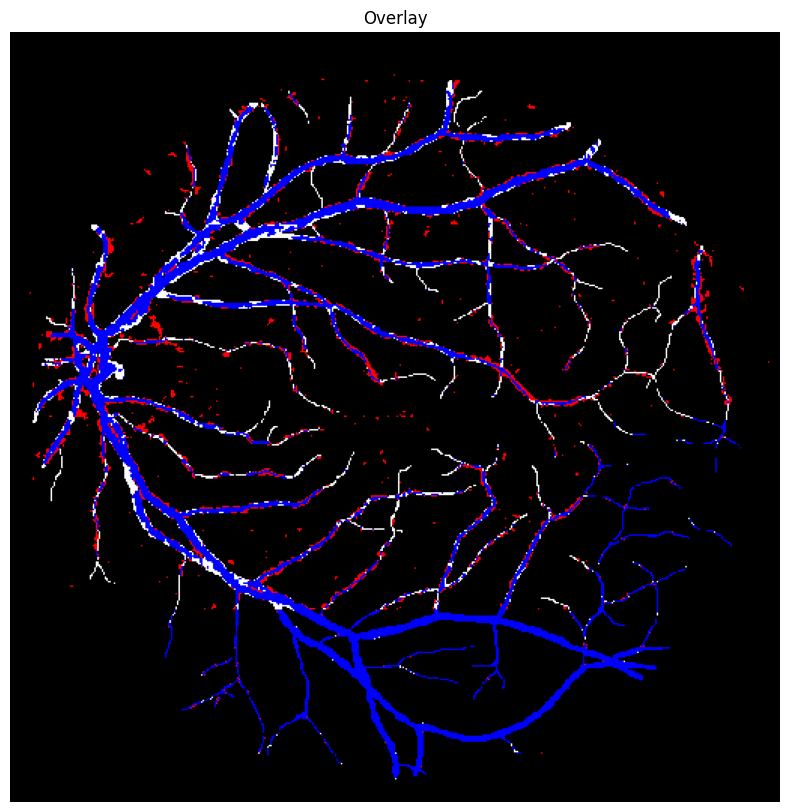

In [132]:
plot_segmentation_results(reconstruct_image(label.numpy()), reconstruct_image(model.predict(image)))

### **Res-NET**

In [143]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

class ResUNet:
    def __init__(self, input_height, input_width, n_channels, n_classes):
        self.input_height = input_height
        self.input_width = input_width
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_height, self.input_width, self.n_channels))

        # Encoder
        conv1 = self.res_block(inputs, 64)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = self.res_block(pool1, 128)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = self.res_block(pool2, 256)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = self.res_block(pool3, 512)
        drop4 = Dropout(0.5)(conv4)

        # Decoder
        up5 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop4))
        merge5 = Concatenate()([conv3,up5])
        conv5 = self.res_block(merge5, 256)

        up6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv5))
        merge6 = Concatenate()([conv2,up6])
        conv6 = self.res_block(merge6, 128)

        up7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
        merge7 = Concatenate()([conv1,up7])
        conv7 = self.res_block(merge7, 64)

        conv8 = Conv2D(self.n_classes, 1, activation='sigmoid')(conv7)

        model = Model(inputs, conv8)
        return model

    def res_block(self, input_tensor, filters, kernel_size=3):
        x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # Skip connection
        x = Concatenate()([x, input_tensor])
        x = tf.keras.layers.Activation('relu')(x)
        return x


In [144]:
data = DatasetPreprocess(image_paths, label_paths, output_type='grayscale',
                         batch_size=32, resize_wh=512, num_crops=4,)

Output a 1 channel image. (grayscale)


In [145]:
train, test = data.get_train_test()

In [146]:
# Create an iterator
dataset_iterator = iter(train)

# Fetch one image-label pair
image, label = next(dataset_iterator)

In [153]:
model = ResUNet(crop_wh, crop_wh, 1, 1).model


In [154]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [155]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_65 (Conv2D)          (None, 128, 128, 64)         640       ['input_15[0][0]']            
                                                                                                  
 batch_normalization_64 (Ba  (None, 128, 128, 64)         256       ['conv2d_65[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_56 (Activation)  (None, 128, 128, 64)         0         ['batch_normalization_64

In [156]:
save_path = 'Resnet_DRIVE.h5'
save_best_only = True

In [157]:
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

Epoch 1/150
1/1 [==============================] - 0s 322ms/step


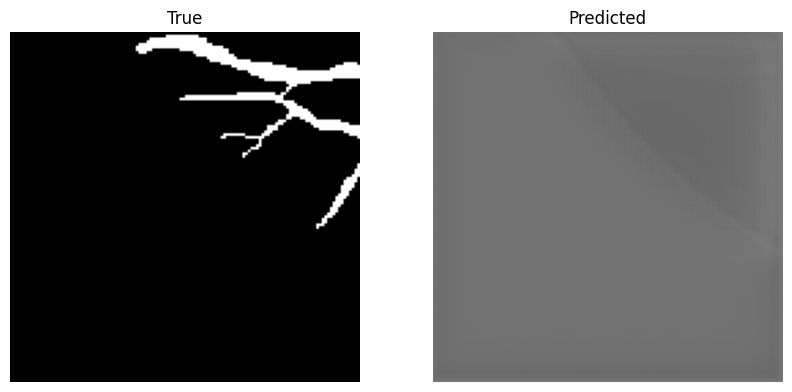


Jaccard: 0.07
Dice: 0.13


Epoch 1: val_loss improved from inf to 0.56026, saving model to Resnet_DRIVE.h5
9/9 - 73s - loss: 0.3202 - accuracy: 0.9128 - val_loss: 0.5603 - val_accuracy: 0.9188 - 73s/epoch - 8s/step
Epoch 2/150

Epoch 2: val_loss improved from 0.56026 to 0.44347, saving model to Resnet_DRIVE.h5
9/9 - 11s - loss: 0.1381 - accuracy: 0.9490 - val_loss: 0.4435 - val_accuracy: 0.9188 - 11s/epoch - 1s/step
Epoch 3/150

Epoch 3: val_loss improved from 0.44347 to 0.41342, saving model to Resnet_DRIVE.h5
9/9 - 11s - loss: 0.1306 - accuracy: 0.9516 - val_loss: 0.4134 - val_accuracy: 0.9188 - 11s/epoch - 1s/step
Epoch 4/150

Epoch 4: val_loss did not improve from 0.41342
9/9 - 10s - loss: 0.1209 - accuracy: 0.9549 - val_loss: 0.4324 - val_accuracy: 0.9188 - 10s/epoch - 1s/step
Epoch 5/150

Epoch 5: val_loss improved from 0.41342 to 0.37713, saving model to Resnet_DRIVE.h5
9/9 - 12s - loss: 0.1200 - accuracy: 0.9553 - val_loss: 0.3771 - val_accuracy: 0.9188 - 12s/epoch - 1s/step
E

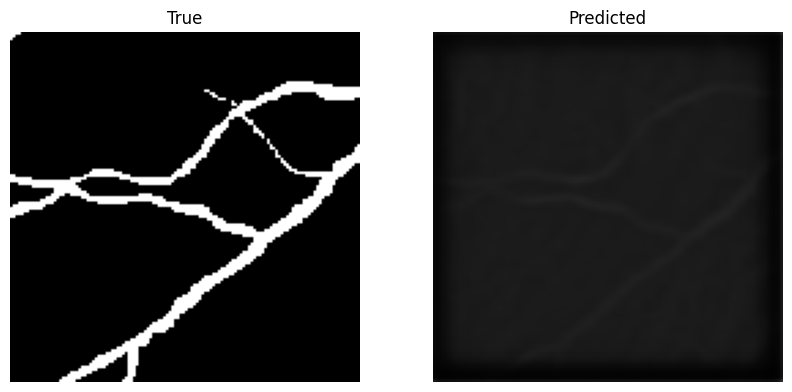


Jaccard: 0.05
Dice: 0.10


Epoch 10: val_loss did not improve from 0.27875
9/9 - 14s - loss: 0.1096 - accuracy: 0.9590 - val_loss: 0.2800 - val_accuracy: 0.9188 - 14s/epoch - 2s/step
Epoch 11/150

Epoch 11: val_loss did not improve from 0.27875
9/9 - 12s - loss: 0.1084 - accuracy: 0.9594 - val_loss: 0.2942 - val_accuracy: 0.9188 - 12s/epoch - 1s/step
Epoch 12/150

Epoch 12: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.1078 - accuracy: 0.9597 - val_loss: 0.3050 - val_accuracy: 0.9188 - 11s/epoch - 1s/step
Epoch 13/150

Epoch 13: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.1057 - accuracy: 0.9603 - val_loss: 0.3033 - val_accuracy: 0.9188 - 11s/epoch - 1s/step
Epoch 14/150

Epoch 14: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.1048 - accuracy: 0.9606 - val_loss: 0.3138 - val_accuracy: 0.9188 - 11s/epoch - 1s/step
Epoch 15/150

Epoch 15: val_loss did not improve from 0.27875
9/9 - 10s - loss: 0.1046 - accuracy: 0.9608 - val_loss: 0.3234 - val_accur

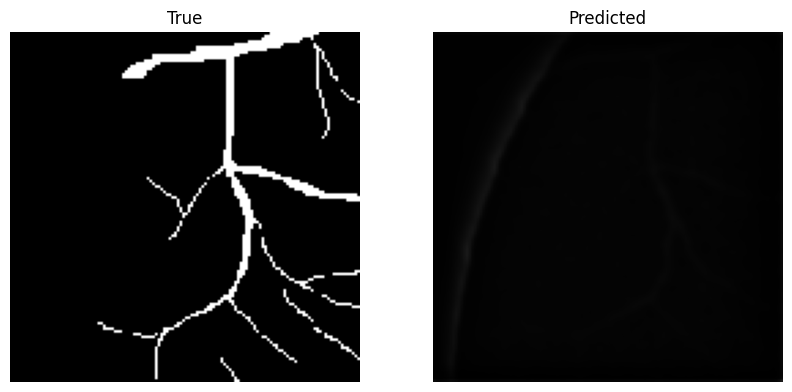


Jaccard: 0.02
Dice: 0.04


Epoch 19: val_loss did not improve from 0.27875
9/9 - 14s - loss: 0.1016 - accuracy: 0.9616 - val_loss: 0.3304 - val_accuracy: 0.9188 - 14s/epoch - 2s/step
Epoch 20/150

Epoch 20: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.0978 - accuracy: 0.9632 - val_loss: 0.3974 - val_accuracy: 0.9188 - 11s/epoch - 1s/step
Epoch 21/150

Epoch 21: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.0974 - accuracy: 0.9635 - val_loss: 0.4216 - val_accuracy: 0.9188 - 11s/epoch - 1s/step
Epoch 22/150

Epoch 22: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.0964 - accuracy: 0.9636 - val_loss: 0.4110 - val_accuracy: 0.9188 - 11s/epoch - 1s/step
Epoch 23/150

Epoch 23: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.0951 - accuracy: 0.9641 - val_loss: 0.3755 - val_accuracy: 0.9188 - 11s/epoch - 1s/step
Epoch 24/150

Epoch 24: val_loss did not improve from 0.27875
9/9 - 13s - loss: 0.0931 - accuracy: 0.9647 - val_loss: 0.4430 - val_accur

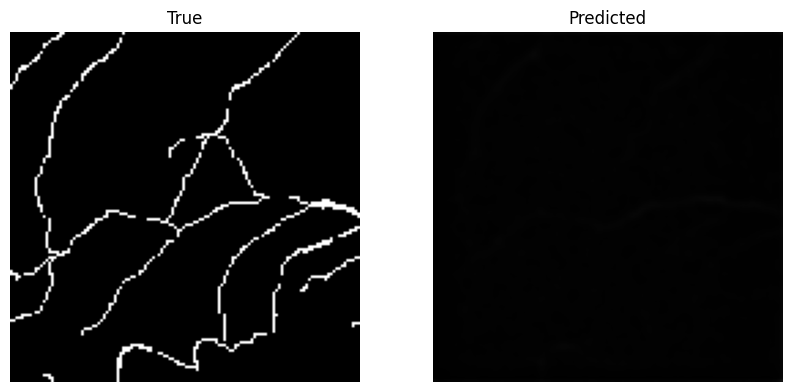


Jaccard: 0.03
Dice: 0.05


Epoch 28: val_loss did not improve from 0.27875
9/9 - 14s - loss: 0.0917 - accuracy: 0.9652 - val_loss: 0.3216 - val_accuracy: 0.9187 - 14s/epoch - 2s/step
Epoch 29/150

Epoch 29: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.0906 - accuracy: 0.9656 - val_loss: 0.3824 - val_accuracy: 0.9187 - 11s/epoch - 1s/step
Epoch 30/150

Epoch 30: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.0889 - accuracy: 0.9660 - val_loss: 0.3692 - val_accuracy: 0.9186 - 11s/epoch - 1s/step
Epoch 31/150

Epoch 31: val_loss did not improve from 0.27875
9/9 - 12s - loss: 0.0882 - accuracy: 0.9663 - val_loss: 0.4009 - val_accuracy: 0.9188 - 12s/epoch - 1s/step
Epoch 32/150

Epoch 32: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.0867 - accuracy: 0.9668 - val_loss: 0.3308 - val_accuracy: 0.9177 - 11s/epoch - 1s/step
Epoch 33/150

Epoch 33: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.0858 - accuracy: 0.9671 - val_loss: 0.3413 - val_accur

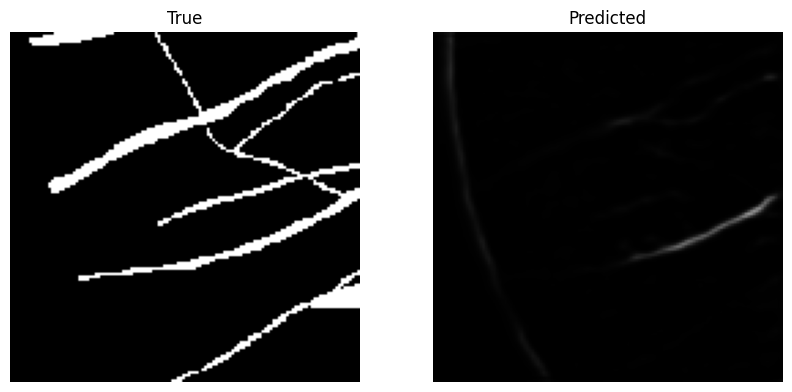


Jaccard: 0.05
Dice: 0.09


Epoch 37: val_loss did not improve from 0.27875
9/9 - 12s - loss: 0.0842 - accuracy: 0.9675 - val_loss: 0.3365 - val_accuracy: 0.9174 - 12s/epoch - 1s/step
Epoch 38/150

Epoch 38: val_loss did not improve from 0.27875
9/9 - 11s - loss: 0.0842 - accuracy: 0.9674 - val_loss: 0.3218 - val_accuracy: 0.9173 - 11s/epoch - 1s/step
Epoch 39/150

Epoch 39: val_loss did not improve from 0.27875
9/9 - 10s - loss: 0.0850 - accuracy: 0.9672 - val_loss: 0.2940 - val_accuracy: 0.9163 - 10s/epoch - 1s/step
Epoch 40/150

Epoch 40: val_loss improved from 0.27875 to 0.27707, saving model to Resnet_DRIVE.h5
9/9 - 12s - loss: 0.0844 - accuracy: 0.9675 - val_loss: 0.2771 - val_accuracy: 0.9189 - 12s/epoch - 1s/step
Epoch 41/150

Epoch 41: val_loss did not improve from 0.27707
9/9 - 11s - loss: 0.0833 - accuracy: 0.9677 - val_loss: 0.3140 - val_accuracy: 0.9172 - 11s/epoch - 1s/step
Epoch 42/150

Epoch 42: val_loss improved from 0.27707 to 0.23237, saving model to Resnet_DRIVE.h5


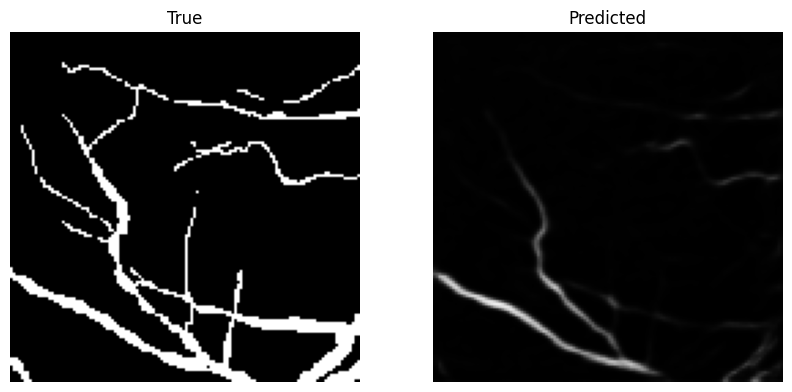


Jaccard: 0.16
Dice: 0.27


Epoch 46: val_loss did not improve from 0.23237
9/9 - 14s - loss: 0.0794 - accuracy: 0.9690 - val_loss: 0.2378 - val_accuracy: 0.9177 - 14s/epoch - 2s/step
Epoch 47/150

Epoch 47: val_loss improved from 0.23237 to 0.22631, saving model to Resnet_DRIVE.h5
9/9 - 11s - loss: 0.0779 - accuracy: 0.9694 - val_loss: 0.2263 - val_accuracy: 0.9214 - 11s/epoch - 1s/step
Epoch 48/150

Epoch 48: val_loss did not improve from 0.22631
9/9 - 11s - loss: 0.0773 - accuracy: 0.9696 - val_loss: 0.2527 - val_accuracy: 0.9237 - 11s/epoch - 1s/step
Epoch 49/150

Epoch 49: val_loss did not improve from 0.22631
9/9 - 12s - loss: 0.0771 - accuracy: 0.9694 - val_loss: 0.3170 - val_accuracy: 0.9150 - 12s/epoch - 1s/step
Epoch 50/150

Epoch 50: val_loss improved from 0.22631 to 0.20626, saving model to Resnet_DRIVE.h5
9/9 - 12s - loss: 0.0809 - accuracy: 0.9681 - val_loss: 0.2063 - val_accuracy: 0.9323 - 12s/epoch - 1s/step
Epoch 51/150

Epoch 51: val_loss did not improve from 0.20626


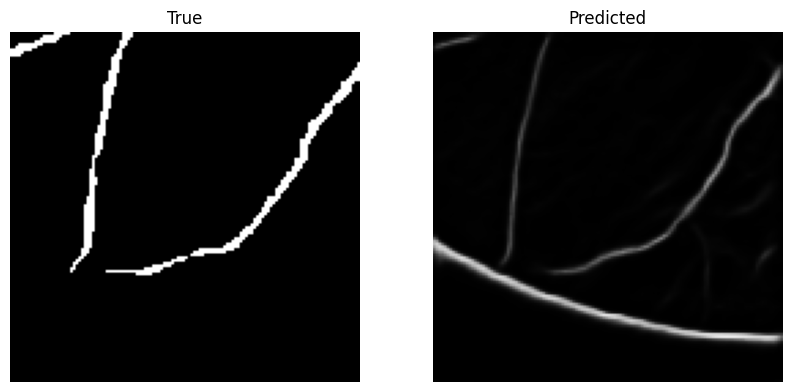


Jaccard: 0.25
Dice: 0.40


Epoch 55: val_loss improved from 0.20626 to 0.18531, saving model to Resnet_DRIVE.h5
9/9 - 14s - loss: 0.0734 - accuracy: 0.9706 - val_loss: 0.1853 - val_accuracy: 0.9312 - 14s/epoch - 2s/step
Epoch 56/150

Epoch 56: val_loss did not improve from 0.18531
9/9 - 11s - loss: 0.0732 - accuracy: 0.9707 - val_loss: 0.2150 - val_accuracy: 0.9293 - 11s/epoch - 1s/step
Epoch 57/150

Epoch 57: val_loss improved from 0.18531 to 0.14131, saving model to Resnet_DRIVE.h5
9/9 - 11s - loss: 0.0717 - accuracy: 0.9710 - val_loss: 0.1413 - val_accuracy: 0.9458 - 11s/epoch - 1s/step
Epoch 58/150

Epoch 58: val_loss did not improve from 0.14131
9/9 - 11s - loss: 0.0742 - accuracy: 0.9701 - val_loss: 0.2157 - val_accuracy: 0.9377 - 11s/epoch - 1s/step
Epoch 59/150

Epoch 59: val_loss did not improve from 0.14131
9/9 - 12s - loss: 0.0759 - accuracy: 0.9697 - val_loss: 0.1861 - val_accuracy: 0.9371 - 12s/epoch - 1s/step
Epoch 60/150

Epoch 60: val_loss did not improve from 0.14131


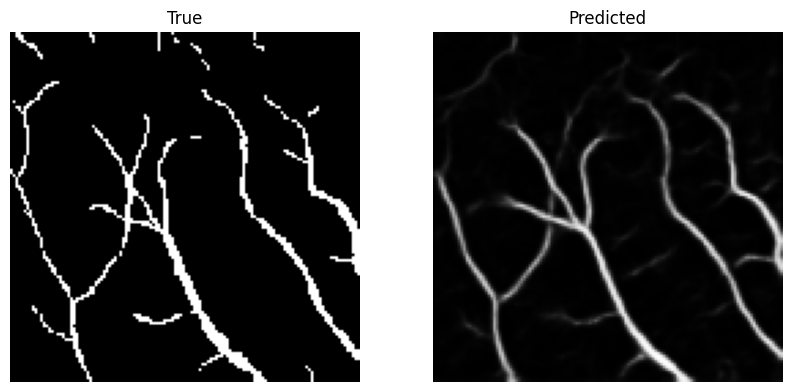


Jaccard: 0.49
Dice: 0.65


Epoch 64: val_loss improved from 0.13900 to 0.10262, saving model to Resnet_DRIVE.h5
9/9 - 15s - loss: 0.0703 - accuracy: 0.9714 - val_loss: 0.1026 - val_accuracy: 0.9603 - 15s/epoch - 2s/step
Epoch 65/150

Epoch 65: val_loss did not improve from 0.10262
9/9 - 11s - loss: 0.0714 - accuracy: 0.9708 - val_loss: 0.1057 - val_accuracy: 0.9591 - 11s/epoch - 1s/step
Epoch 66/150

Epoch 66: val_loss improved from 0.10262 to 0.10051, saving model to Resnet_DRIVE.h5
9/9 - 11s - loss: 0.0717 - accuracy: 0.9709 - val_loss: 0.1005 - val_accuracy: 0.9634 - 11s/epoch - 1s/step
Epoch 67/150

Epoch 67: val_loss did not improve from 0.10051
9/9 - 11s - loss: 0.0704 - accuracy: 0.9713 - val_loss: 0.1320 - val_accuracy: 0.9584 - 11s/epoch - 1s/step
Epoch 68/150

Epoch 68: val_loss did not improve from 0.10051
9/9 - 11s - loss: 0.0697 - accuracy: 0.9716 - val_loss: 0.1009 - val_accuracy: 0.9613 - 11s/epoch - 1s/step
Epoch 69/150

Epoch 69: val_loss improved from 0.10051 to 0.09

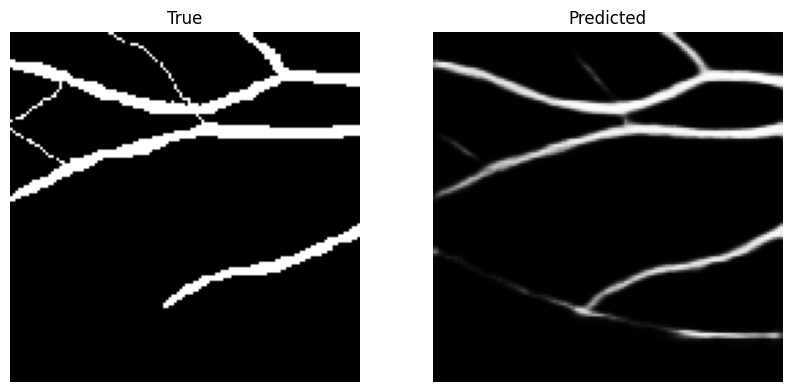


Jaccard: 0.48
Dice: 0.65


Epoch 73: val_loss did not improve from 0.08653
9/9 - 14s - loss: 0.0623 - accuracy: 0.9737 - val_loss: 0.1116 - val_accuracy: 0.9613 - 14s/epoch - 2s/step
Epoch 74/150

Epoch 74: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0608 - accuracy: 0.9741 - val_loss: 0.0873 - val_accuracy: 0.9671 - 11s/epoch - 1s/step
Epoch 75/150

Epoch 75: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0615 - accuracy: 0.9738 - val_loss: 0.0900 - val_accuracy: 0.9674 - 12s/epoch - 1s/step
Epoch 76/150

Epoch 76: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0596 - accuracy: 0.9744 - val_loss: 0.0993 - val_accuracy: 0.9649 - 12s/epoch - 1s/step
Epoch 77/150

Epoch 77: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0587 - accuracy: 0.9747 - val_loss: 0.0878 - val_accuracy: 0.9670 - 12s/epoch - 1s/step
Epoch 78/150

Epoch 78: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0575 - accuracy: 0.9754 - val_loss: 0.1070 - val_accur

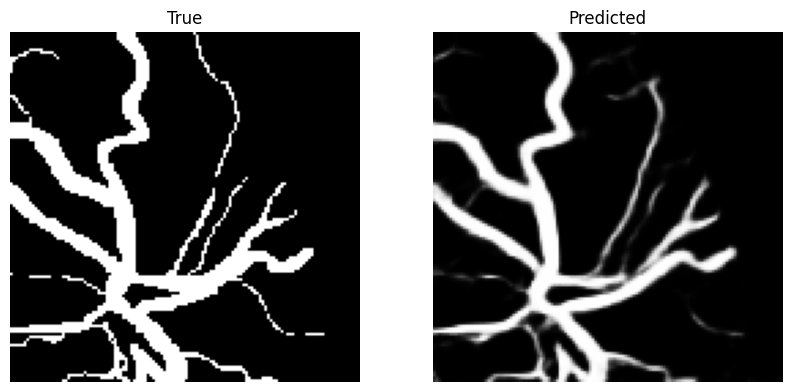


Jaccard: 0.63
Dice: 0.77


Epoch 82: val_loss did not improve from 0.08653
9/9 - 14s - loss: 0.0537 - accuracy: 0.9767 - val_loss: 0.0957 - val_accuracy: 0.9672 - 14s/epoch - 2s/step
Epoch 83/150

Epoch 83: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0536 - accuracy: 0.9768 - val_loss: 0.0983 - val_accuracy: 0.9670 - 11s/epoch - 1s/step
Epoch 84/150

Epoch 84: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0534 - accuracy: 0.9768 - val_loss: 0.1055 - val_accuracy: 0.9660 - 11s/epoch - 1s/step
Epoch 85/150

Epoch 85: val_loss did not improve from 0.08653
9/9 - 10s - loss: 0.0512 - accuracy: 0.9777 - val_loss: 0.1014 - val_accuracy: 0.9670 - 10s/epoch - 1s/step
Epoch 86/150

Epoch 86: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0514 - accuracy: 0.9778 - val_loss: 0.0997 - val_accuracy: 0.9668 - 11s/epoch - 1s/step
Epoch 87/150

Epoch 87: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0513 - accuracy: 0.9777 - val_loss: 0.1074 - val_accur

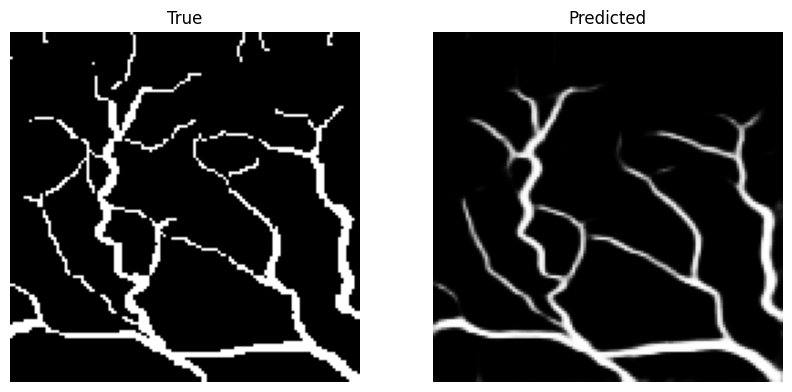


Jaccard: 0.63
Dice: 0.78


Epoch 91: val_loss did not improve from 0.08653
9/9 - 13s - loss: 0.0484 - accuracy: 0.9791 - val_loss: 0.1211 - val_accuracy: 0.9652 - 13s/epoch - 1s/step
Epoch 92/150

Epoch 92: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0512 - accuracy: 0.9779 - val_loss: 0.1263 - val_accuracy: 0.9651 - 12s/epoch - 1s/step
Epoch 93/150

Epoch 93: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0471 - accuracy: 0.9797 - val_loss: 0.1047 - val_accuracy: 0.9669 - 11s/epoch - 1s/step
Epoch 94/150

Epoch 94: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0452 - accuracy: 0.9804 - val_loss: 0.1267 - val_accuracy: 0.9635 - 11s/epoch - 1s/step
Epoch 95/150

Epoch 95: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0443 - accuracy: 0.9808 - val_loss: 0.1210 - val_accuracy: 0.9644 - 11s/epoch - 1s/step
Epoch 96/150

Epoch 96: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0448 - accuracy: 0.9806 - val_loss: 0.1105 - val_accur

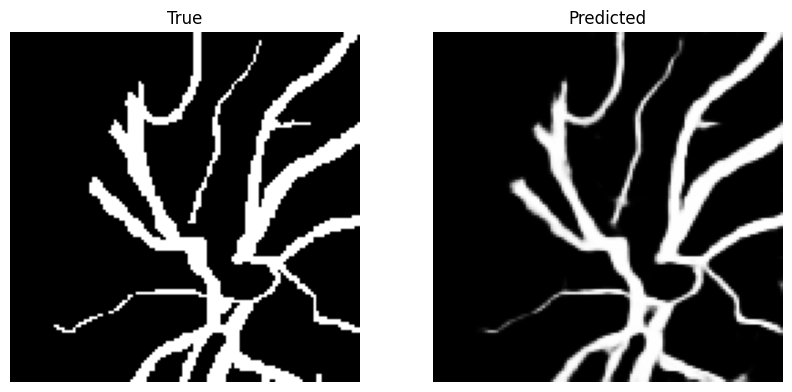


Jaccard: 0.70
Dice: 0.82


Epoch 100: val_loss did not improve from 0.08653
9/9 - 13s - loss: 0.0420 - accuracy: 0.9818 - val_loss: 0.1089 - val_accuracy: 0.9669 - 13s/epoch - 1s/step
Epoch 101/150

Epoch 101: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0424 - accuracy: 0.9816 - val_loss: 0.1087 - val_accuracy: 0.9663 - 11s/epoch - 1s/step
Epoch 102/150

Epoch 102: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0434 - accuracy: 0.9813 - val_loss: 0.1070 - val_accuracy: 0.9671 - 11s/epoch - 1s/step
Epoch 103/150

Epoch 103: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0425 - accuracy: 0.9817 - val_loss: 0.1111 - val_accuracy: 0.9664 - 11s/epoch - 1s/step
Epoch 104/150

Epoch 104: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0400 - accuracy: 0.9827 - val_loss: 0.1047 - val_accuracy: 0.9674 - 11s/epoch - 1s/step
Epoch 105/150

Epoch 105: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0366 - accuracy: 0.9842 - val_loss: 0.1033 

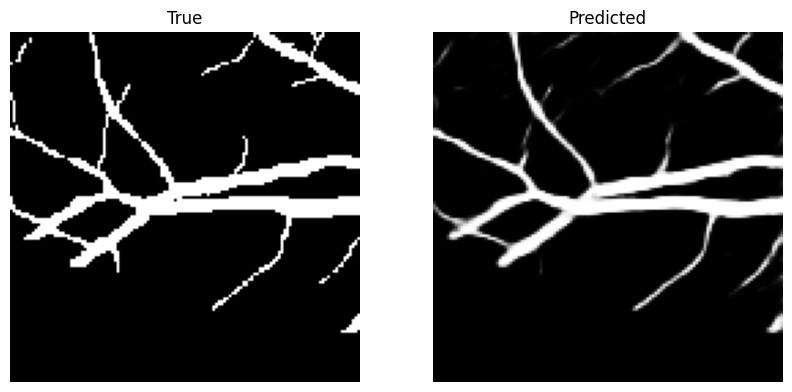


Jaccard: 0.72
Dice: 0.84


Epoch 109: val_loss did not improve from 0.08653
9/9 - 14s - loss: 0.0369 - accuracy: 0.9841 - val_loss: 0.1078 - val_accuracy: 0.9662 - 14s/epoch - 2s/step
Epoch 110/150

Epoch 110: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0399 - accuracy: 0.9829 - val_loss: 0.1151 - val_accuracy: 0.9660 - 12s/epoch - 1s/step
Epoch 111/150

Epoch 111: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0357 - accuracy: 0.9847 - val_loss: 0.1103 - val_accuracy: 0.9671 - 11s/epoch - 1s/step
Epoch 112/150

Epoch 112: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0359 - accuracy: 0.9845 - val_loss: 0.1467 - val_accuracy: 0.9625 - 11s/epoch - 1s/step
Epoch 113/150

Epoch 113: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0338 - accuracy: 0.9856 - val_loss: 0.1169 - val_accuracy: 0.9666 - 12s/epoch - 1s/step
Epoch 114/150

Epoch 114: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0317 - accuracy: 0.9865 - val_loss: 0.1225 

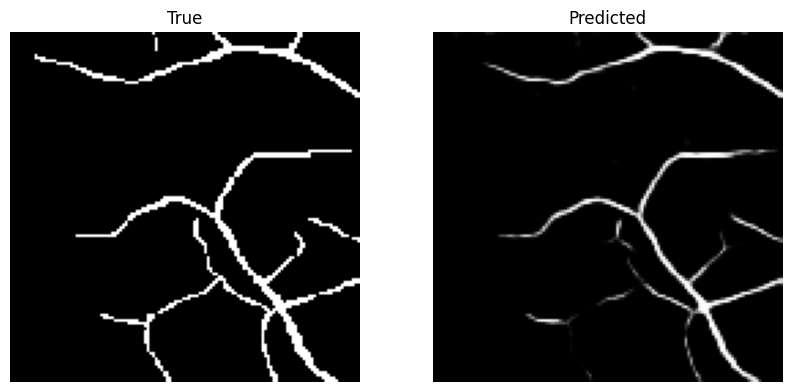


Jaccard: 0.75
Dice: 0.86


Epoch 118: val_loss did not improve from 0.08653
9/9 - 13s - loss: 0.0274 - accuracy: 0.9884 - val_loss: 0.1225 - val_accuracy: 0.9670 - 13s/epoch - 1s/step
Epoch 119/150

Epoch 119: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0269 - accuracy: 0.9886 - val_loss: 0.1313 - val_accuracy: 0.9660 - 11s/epoch - 1s/step
Epoch 120/150

Epoch 120: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0267 - accuracy: 0.9887 - val_loss: 0.1234 - val_accuracy: 0.9666 - 11s/epoch - 1s/step
Epoch 121/150

Epoch 121: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0256 - accuracy: 0.9892 - val_loss: 0.1260 - val_accuracy: 0.9674 - 12s/epoch - 1s/step
Epoch 122/150

Epoch 122: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0258 - accuracy: 0.9891 - val_loss: 0.1365 - val_accuracy: 0.9663 - 12s/epoch - 1s/step
Epoch 123/150

Epoch 123: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0253 - accuracy: 0.9894 - val_loss: 0.1300 

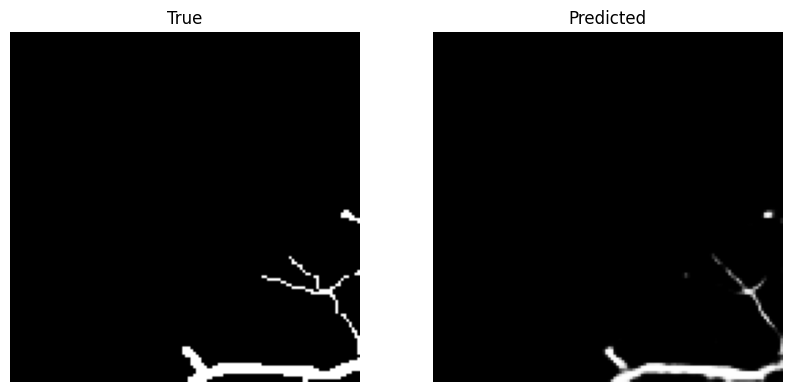


Jaccard: 0.79
Dice: 0.88


Epoch 127: val_loss did not improve from 0.08653
9/9 - 14s - loss: 0.0255 - accuracy: 0.9894 - val_loss: 0.1410 - val_accuracy: 0.9664 - 14s/epoch - 2s/step
Epoch 128/150

Epoch 128: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0244 - accuracy: 0.9897 - val_loss: 0.1471 - val_accuracy: 0.9619 - 12s/epoch - 1s/step
Epoch 129/150

Epoch 129: val_loss did not improve from 0.08653
9/9 - 13s - loss: 0.0246 - accuracy: 0.9896 - val_loss: 0.1395 - val_accuracy: 0.9660 - 13s/epoch - 1s/step
Epoch 130/150

Epoch 130: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0231 - accuracy: 0.9904 - val_loss: 0.1374 - val_accuracy: 0.9648 - 11s/epoch - 1s/step
Epoch 131/150

Epoch 131: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0216 - accuracy: 0.9910 - val_loss: 0.1371 - val_accuracy: 0.9649 - 11s/epoch - 1s/step
Epoch 132/150

Epoch 132: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0231 - accuracy: 0.9904 - val_loss: 0.1414 

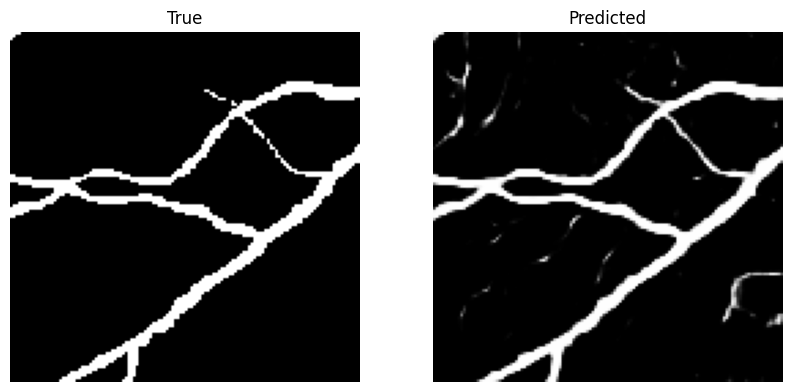


Jaccard: 0.84
Dice: 0.92


Epoch 136: val_loss did not improve from 0.08653
9/9 - 13s - loss: 0.0220 - accuracy: 0.9908 - val_loss: 0.1440 - val_accuracy: 0.9623 - 13s/epoch - 1s/step
Epoch 137/150

Epoch 137: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0222 - accuracy: 0.9908 - val_loss: 0.1473 - val_accuracy: 0.9643 - 12s/epoch - 1s/step
Epoch 138/150

Epoch 138: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0208 - accuracy: 0.9914 - val_loss: 0.1413 - val_accuracy: 0.9654 - 11s/epoch - 1s/step
Epoch 139/150

Epoch 139: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0208 - accuracy: 0.9913 - val_loss: 0.1461 - val_accuracy: 0.9657 - 11s/epoch - 1s/step
Epoch 140/150

Epoch 140: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0209 - accuracy: 0.9913 - val_loss: 0.1418 - val_accuracy: 0.9661 - 11s/epoch - 1s/step
Epoch 141/150

Epoch 141: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0191 - accuracy: 0.9921 - val_loss: 0.1493 

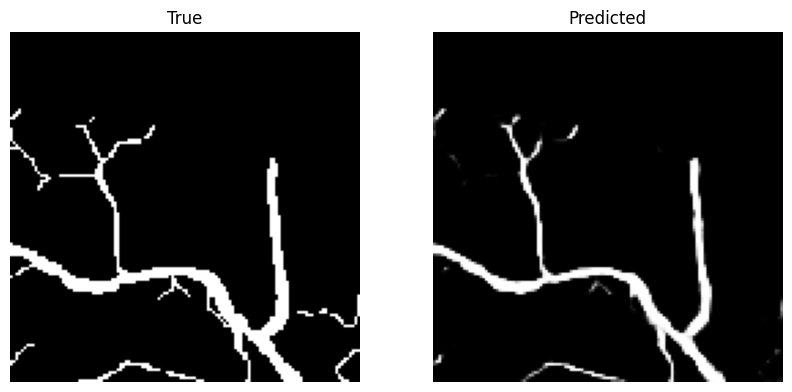


Jaccard: 0.77
Dice: 0.87


Epoch 145: val_loss did not improve from 0.08653
9/9 - 14s - loss: 0.0183 - accuracy: 0.9925 - val_loss: 0.1631 - val_accuracy: 0.9663 - 14s/epoch - 2s/step
Epoch 146/150

Epoch 146: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0159 - accuracy: 0.9936 - val_loss: 0.1576 - val_accuracy: 0.9666 - 12s/epoch - 1s/step
Epoch 147/150

Epoch 147: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0142 - accuracy: 0.9943 - val_loss: 0.1594 - val_accuracy: 0.9665 - 11s/epoch - 1s/step
Epoch 148/150

Epoch 148: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0140 - accuracy: 0.9943 - val_loss: 0.1642 - val_accuracy: 0.9664 - 11s/epoch - 1s/step
Epoch 149/150

Epoch 149: val_loss did not improve from 0.08653
9/9 - 11s - loss: 0.0138 - accuracy: 0.9945 - val_loss: 0.1705 - val_accuracy: 0.9671 - 11s/epoch - 1s/step
Epoch 150/150

Epoch 150: val_loss did not improve from 0.08653
9/9 - 12s - loss: 0.0143 - accuracy: 0.9942 - val_loss: 0.1766 

In [158]:
history = model.fit(train, epochs=150, verbose=2,
                    callbacks=[CustomCallback(model, train), checkpointer],
                    validation_data=test)

In [159]:
test_data = DatasetPreprocess(test_image_paths, test_label_paths, output_type='grayscale',
                              batch_size=32, resize_wh=512, num_crops=4,
                              split_dataset=False, is_test=True)

Output a 1 channel image. (grayscale)


In [160]:
test = test_data.get_dataset()

In [161]:
_ = model.evaluate(test)

20/20 [==============================] - 9s 141ms/step - loss: 0.0715 - accuracy: 0.9812


In [162]:
# Create an iterator
dataset_iterator = iter(test)

# Fetch one image-label pair
image, label = next(dataset_iterator)

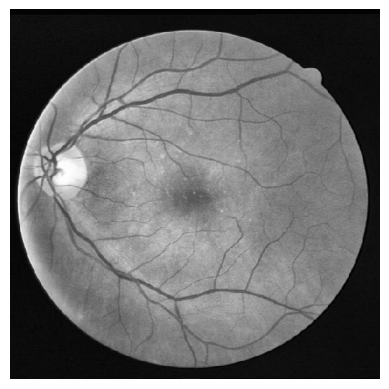

In [163]:
display_image(reconstruct_image(image.numpy()))

1/1 [==============================] - 0s 453ms/step


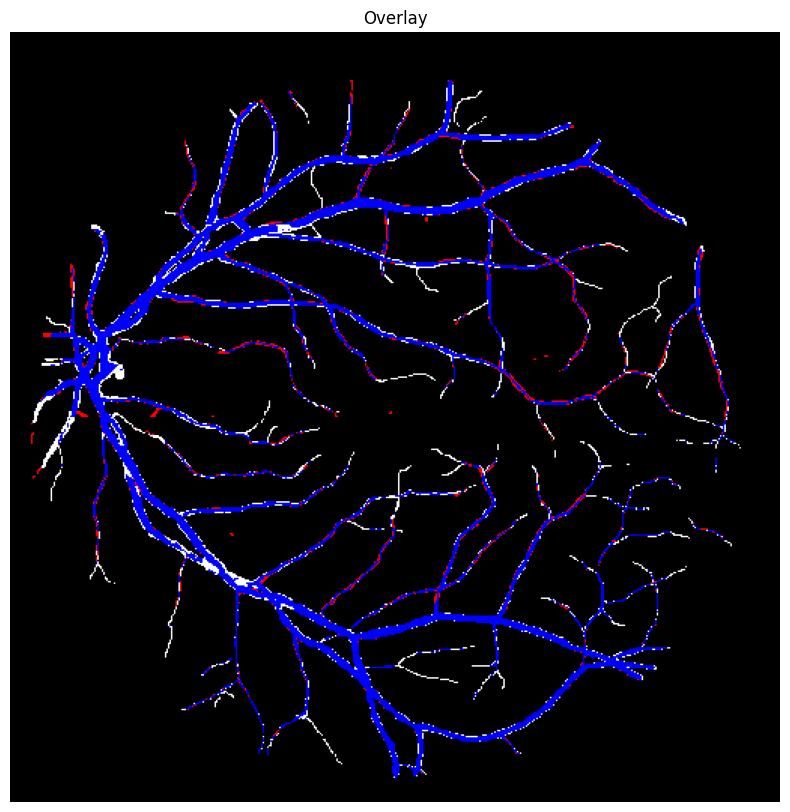

In [164]:
plot_segmentation_results(reconstruct_image(label.numpy()), reconstruct_image(model.predict(image)))

## **MobileNetV2**

## **Preprocess and Display Images**

In [165]:
data = DatasetPreprocess(image_paths, label_paths, output_type='color',
                         batch_size=32, resize_wh=512, num_crops=4,)
train, test = data.get_train_test()

Output a 3 channel image.


In [166]:
# Create an iterator
dataset_iterator = iter(train)

# Fetch one image-label pair
image, label = next(dataset_iterator)

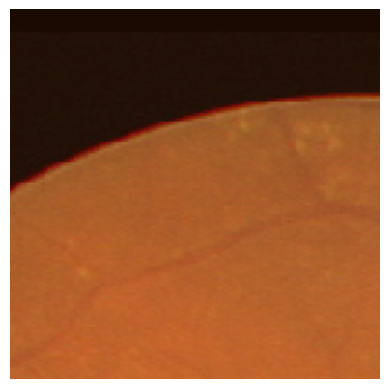

In [167]:
display_image(image[0, ...])

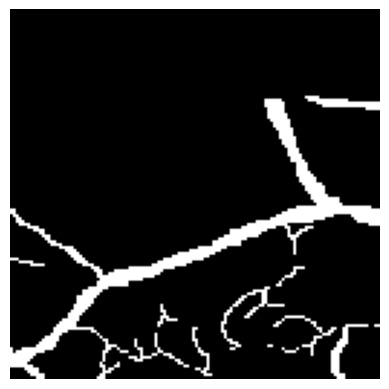

In [168]:
display_image(label[0, ...])

In [169]:
model = MV2(input_shape=[crop_wh, crop_wh, 3]).build()
model.compile(optimizer='adam', loss=combined_loss,
              metrics=['accuracy'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_83 (Conv2D)          (None, 64, 64, 32)           896       ['input_16[0][0]']            
                                                                                                  
 batch_normalization_78 (Ba  (None, 64, 64, 32)           128       ['conv2d_83[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 tf.nn.relu (TFOpLambda)     (None, 64, 64, 32)           0         ['batch_normalization_78

In [170]:
save_path = 'MV2net_DRIVE.h5'
save_best_only = True
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

Epoch 1/150
1/1 [==============================] - 1s 903ms/step


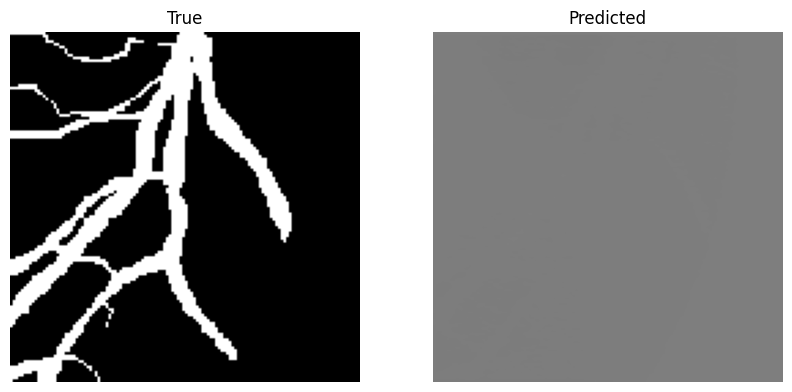


Jaccard: 0.08
Dice: 0.14


Epoch 1: val_loss improved from inf to 0.95639, saving model to MV2net_DRIVE.h5
9/9 - 43s - loss: 1.0356 - accuracy: 0.4403 - val_loss: 0.9564 - val_accuracy: 0.9188 - 43s/epoch - 5s/step
Epoch 2/150

Epoch 2: val_loss improved from 0.95639 to 0.95329, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 1.0072 - accuracy: 0.4445 - val_loss: 0.9533 - val_accuracy: 0.9188 - 4s/epoch - 466ms/step
Epoch 3/150

Epoch 3: val_loss improved from 0.95329 to 0.95026, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.9898 - accuracy: 0.4491 - val_loss: 0.9503 - val_accuracy: 0.9188 - 3s/epoch - 336ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.95026 to 0.94530, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.9698 - accuracy: 0.4819 - val_loss: 0.9453 - val_accuracy: 0.9188 - 3s/epoch - 334ms/step
Epoch 5/150

Epoch 5: val_loss improved from 0.94530 to 0.93438, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.9299 - accuracy: 0.5517 - val_loss: 0.9344 - val_a

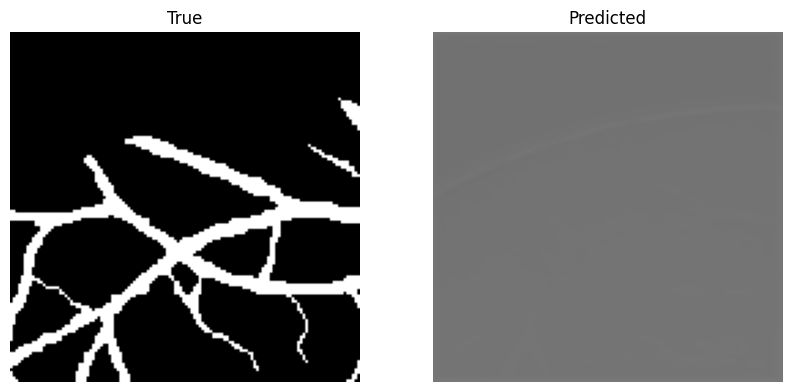


Jaccard: 0.09
Dice: 0.16


Epoch 10: val_loss improved from 0.89882 to 0.88902, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.8354 - accuracy: 0.8788 - val_loss: 0.8890 - val_accuracy: 0.9188 - 5s/epoch - 518ms/step
Epoch 11/150

Epoch 11: val_loss improved from 0.88902 to 0.88225, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.8248 - accuracy: 0.8865 - val_loss: 0.8823 - val_accuracy: 0.9188 - 5s/epoch - 588ms/step
Epoch 12/150

Epoch 12: val_loss improved from 0.88225 to 0.87468, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.8161 - accuracy: 0.8893 - val_loss: 0.8747 - val_accuracy: 0.9188 - 3s/epoch - 382ms/step
Epoch 13/150

Epoch 13: val_loss improved from 0.87468 to 0.86726, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.8112 - accuracy: 0.8956 - val_loss: 0.8673 - val_accuracy: 0.9188 - 4s/epoch - 475ms/step
Epoch 14/150

Epoch 14: val_loss improved from 0.86726 to 0.85869, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.8027 - accuracy: 0.9034 - val_loss: 

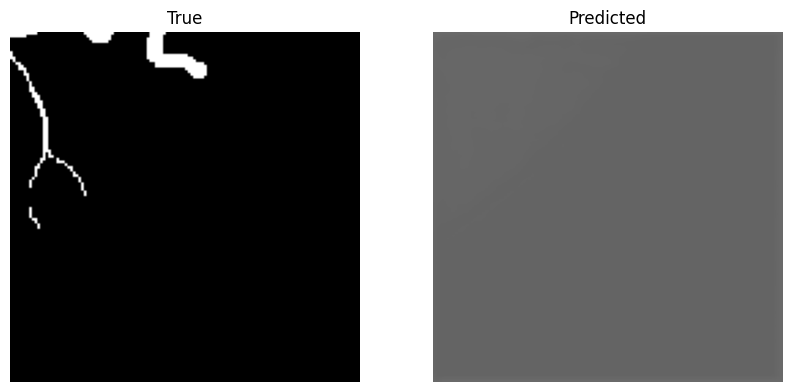


Jaccard: 0.07
Dice: 0.13


Epoch 19: val_loss improved from 0.82673 to 0.82026, saving model to MV2net_DRIVE.h5
9/9 - 6s - loss: 0.7744 - accuracy: 0.9158 - val_loss: 0.8203 - val_accuracy: 0.9188 - 6s/epoch - 664ms/step
Epoch 20/150

Epoch 20: val_loss improved from 0.82026 to 0.81501, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7656 - accuracy: 0.9167 - val_loss: 0.8150 - val_accuracy: 0.9188 - 3s/epoch - 338ms/step
Epoch 21/150

Epoch 21: val_loss improved from 0.81501 to 0.80915, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.7605 - accuracy: 0.9198 - val_loss: 0.8091 - val_accuracy: 0.9188 - 5s/epoch - 533ms/step
Epoch 22/150

Epoch 22: val_loss improved from 0.80915 to 0.80684, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7545 - accuracy: 0.9222 - val_loss: 0.8068 - val_accuracy: 0.9188 - 3s/epoch - 385ms/step
Epoch 23/150

Epoch 23: val_loss improved from 0.80684 to 0.80264, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7521 - accuracy: 0.9189 - val_loss: 

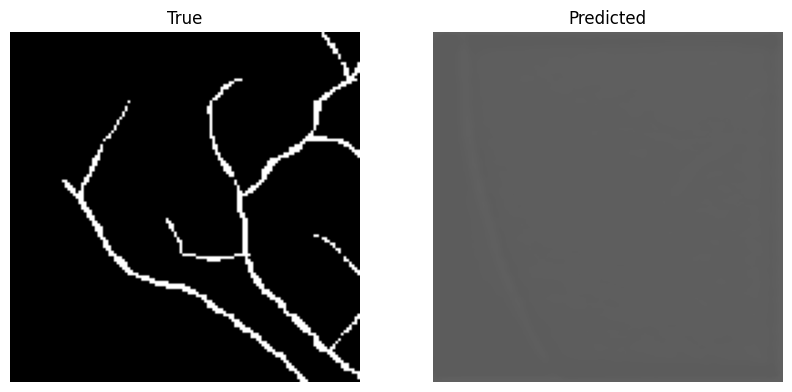


Jaccard: 0.08
Dice: 0.14


Epoch 28: val_loss improved from 0.78544 to 0.78542, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.7294 - accuracy: 0.9256 - val_loss: 0.7854 - val_accuracy: 0.9188 - 4s/epoch - 479ms/step
Epoch 29/150

Epoch 29: val_loss improved from 0.78542 to 0.77813, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7226 - accuracy: 0.9325 - val_loss: 0.7781 - val_accuracy: 0.9188 - 3s/epoch - 379ms/step
Epoch 30/150

Epoch 30: val_loss improved from 0.77813 to 0.77521, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.7183 - accuracy: 0.9326 - val_loss: 0.7752 - val_accuracy: 0.9188 - 4s/epoch - 399ms/step
Epoch 31/150

Epoch 31: val_loss improved from 0.77521 to 0.77167, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.7140 - accuracy: 0.9347 - val_loss: 0.7717 - val_accuracy: 0.9188 - 3s/epoch - 383ms/step
Epoch 32/150

Epoch 32: val_loss improved from 0.77167 to 0.76866, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.7088 - accuracy: 0.9351 - val_loss: 

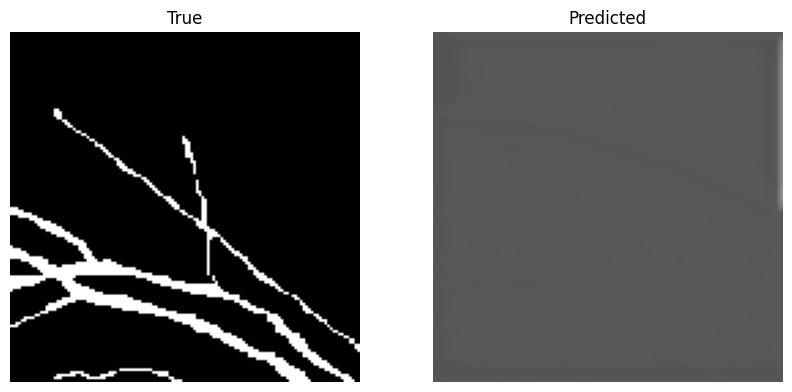


Jaccard: 0.07
Dice: 0.14


Epoch 37: val_loss did not improve from 0.75362
9/9 - 4s - loss: 0.6889 - accuracy: 0.9382 - val_loss: 0.7545 - val_accuracy: 0.9173 - 4s/epoch - 460ms/step
Epoch 38/150

Epoch 38: val_loss improved from 0.75362 to 0.74924, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.6853 - accuracy: 0.9402 - val_loss: 0.7492 - val_accuracy: 0.9157 - 4s/epoch - 395ms/step
Epoch 39/150

Epoch 39: val_loss improved from 0.74924 to 0.74286, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6835 - accuracy: 0.9386 - val_loss: 0.7429 - val_accuracy: 0.9159 - 3s/epoch - 330ms/step
Epoch 40/150

Epoch 40: val_loss did not improve from 0.74286
9/9 - 3s - loss: 0.6762 - accuracy: 0.9443 - val_loss: 0.7446 - val_accuracy: 0.9138 - 3s/epoch - 321ms/step
Epoch 41/150

Epoch 41: val_loss improved from 0.74286 to 0.74164, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6722 - accuracy: 0.9427 - val_loss: 0.7416 - val_accuracy: 0.9130 - 3s/epoch - 384ms/step
Epoch 42/150

Epoch 

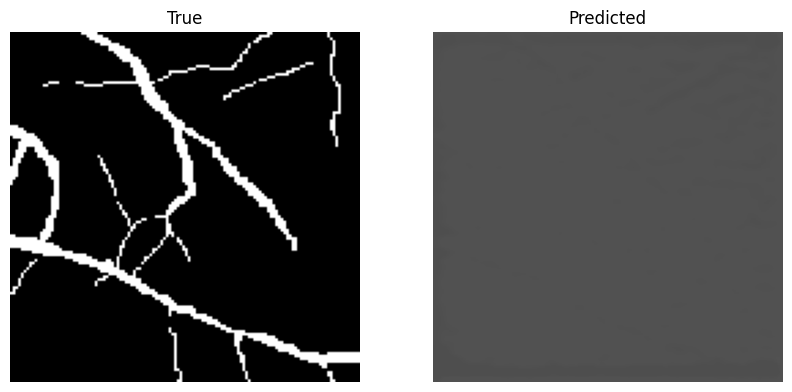


Jaccard: 0.08
Dice: 0.14


Epoch 46: val_loss improved from 0.73180 to 0.72927, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.6547 - accuracy: 0.9486 - val_loss: 0.7293 - val_accuracy: 0.9107 - 5s/epoch - 516ms/step
Epoch 47/150

Epoch 47: val_loss improved from 0.72927 to 0.72780, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6522 - accuracy: 0.9462 - val_loss: 0.7278 - val_accuracy: 0.9095 - 3s/epoch - 348ms/step
Epoch 48/150

Epoch 48: val_loss improved from 0.72780 to 0.72280, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6499 - accuracy: 0.9474 - val_loss: 0.7228 - val_accuracy: 0.9103 - 3s/epoch - 376ms/step
Epoch 49/150

Epoch 49: val_loss improved from 0.72280 to 0.72041, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6455 - accuracy: 0.9462 - val_loss: 0.7204 - val_accuracy: 0.9106 - 3s/epoch - 329ms/step
Epoch 50/150

Epoch 50: val_loss improved from 0.72041 to 0.71486, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6417 - accuracy: 0.9495 - val_loss: 

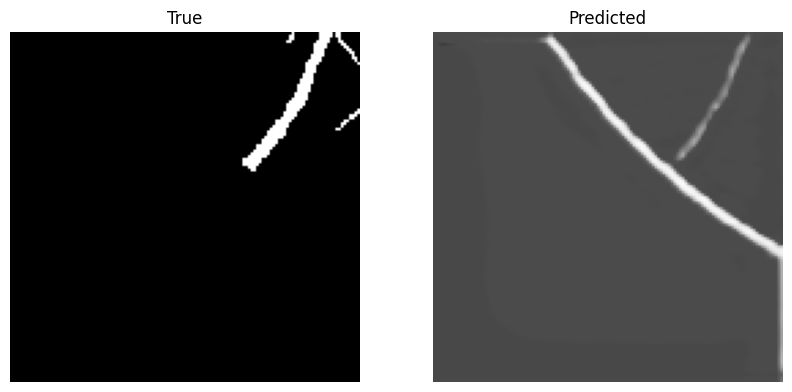


Jaccard: 0.09
Dice: 0.16


Epoch 55: val_loss improved from 0.69146 to 0.68995, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.6241 - accuracy: 0.9508 - val_loss: 0.6900 - val_accuracy: 0.9211 - 5s/epoch - 528ms/step
Epoch 56/150

Epoch 56: val_loss improved from 0.68995 to 0.67746, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6194 - accuracy: 0.9524 - val_loss: 0.6775 - val_accuracy: 0.9269 - 3s/epoch - 334ms/step
Epoch 57/150

Epoch 57: val_loss improved from 0.67746 to 0.66903, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.6155 - accuracy: 0.9543 - val_loss: 0.6690 - val_accuracy: 0.9297 - 5s/epoch - 539ms/step
Epoch 58/150

Epoch 58: val_loss improved from 0.66903 to 0.66285, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6129 - accuracy: 0.9529 - val_loss: 0.6628 - val_accuracy: 0.9324 - 3s/epoch - 333ms/step
Epoch 59/150

Epoch 59: val_loss improved from 0.66285 to 0.65343, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.6102 - accuracy: 0.9533 - val_loss: 

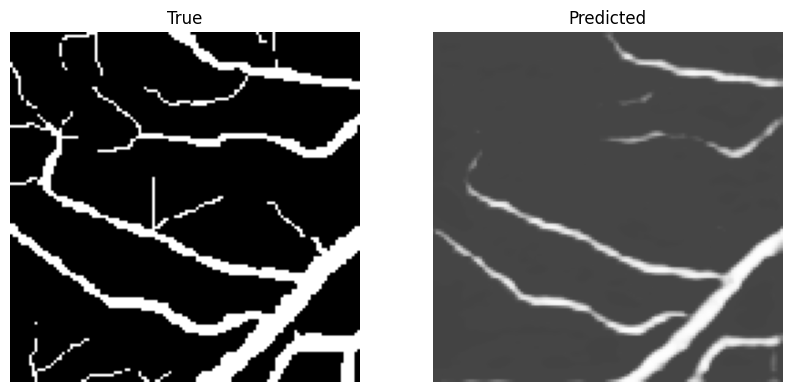


Jaccard: 0.17
Dice: 0.29


Epoch 64: val_loss improved from 0.63354 to 0.62464, saving model to MV2net_DRIVE.h5
9/9 - 6s - loss: 0.5961 - accuracy: 0.9541 - val_loss: 0.6246 - val_accuracy: 0.9452 - 6s/epoch - 613ms/step
Epoch 65/150

Epoch 65: val_loss improved from 0.62464 to 0.61720, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5955 - accuracy: 0.9539 - val_loss: 0.6172 - val_accuracy: 0.9487 - 3s/epoch - 332ms/step
Epoch 66/150

Epoch 66: val_loss improved from 0.61720 to 0.60881, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5893 - accuracy: 0.9568 - val_loss: 0.6088 - val_accuracy: 0.9517 - 3s/epoch - 379ms/step
Epoch 67/150

Epoch 67: val_loss improved from 0.60881 to 0.60625, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.5877 - accuracy: 0.9561 - val_loss: 0.6063 - val_accuracy: 0.9516 - 4s/epoch - 394ms/step
Epoch 68/150

Epoch 68: val_loss improved from 0.60625 to 0.59754, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.5853 - accuracy: 0.9547 - val_loss: 

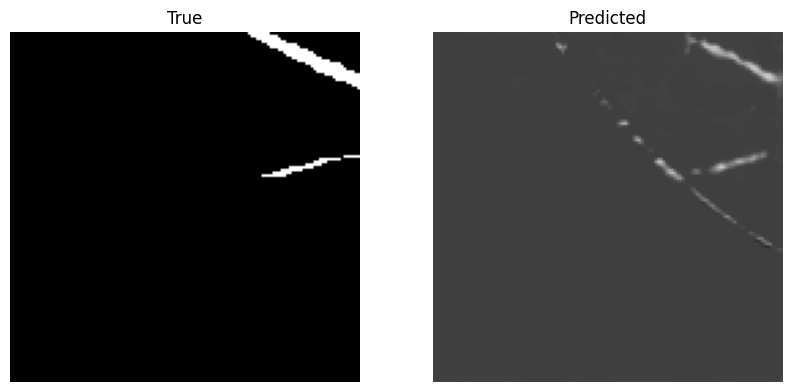


Jaccard: 0.17
Dice: 0.29


Epoch 73: val_loss improved from 0.58412 to 0.57645, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.5689 - accuracy: 0.9598 - val_loss: 0.5765 - val_accuracy: 0.9600 - 4s/epoch - 479ms/step
Epoch 74/150

Epoch 74: val_loss improved from 0.57645 to 0.57501, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.5667 - accuracy: 0.9580 - val_loss: 0.5750 - val_accuracy: 0.9599 - 5s/epoch - 546ms/step
Epoch 75/150

Epoch 75: val_loss improved from 0.57501 to 0.57331, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5639 - accuracy: 0.9580 - val_loss: 0.5733 - val_accuracy: 0.9597 - 3s/epoch - 337ms/step
Epoch 76/150

Epoch 76: val_loss improved from 0.57331 to 0.56918, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5609 - accuracy: 0.9600 - val_loss: 0.5692 - val_accuracy: 0.9602 - 3s/epoch - 329ms/step
Epoch 77/150

Epoch 77: val_loss improved from 0.56918 to 0.56882, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5595 - accuracy: 0.9585 - val_loss: 

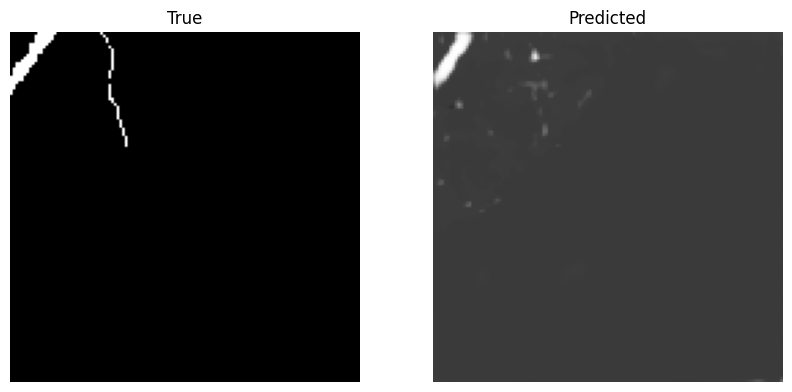


Jaccard: 0.21
Dice: 0.35


Epoch 82: val_loss improved from 0.55552 to 0.55325, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.5474 - accuracy: 0.9598 - val_loss: 0.5532 - val_accuracy: 0.9586 - 5s/epoch - 526ms/step
Epoch 83/150

Epoch 83: val_loss improved from 0.55325 to 0.55259, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.5438 - accuracy: 0.9589 - val_loss: 0.5526 - val_accuracy: 0.9576 - 4s/epoch - 423ms/step
Epoch 84/150

Epoch 84: val_loss did not improve from 0.55259
9/9 - 3s - loss: 0.5408 - accuracy: 0.9613 - val_loss: 0.5571 - val_accuracy: 0.9545 - 3s/epoch - 322ms/step
Epoch 85/150

Epoch 85: val_loss improved from 0.55259 to 0.54627, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5396 - accuracy: 0.9593 - val_loss: 0.5463 - val_accuracy: 0.9585 - 3s/epoch - 386ms/step
Epoch 86/150

Epoch 86: val_loss did not improve from 0.54627
9/9 - 3s - loss: 0.5369 - accuracy: 0.9617 - val_loss: 0.5465 - val_accuracy: 0.9575 - 3s/epoch - 368ms/step
Epoch 87/150

Epoch 

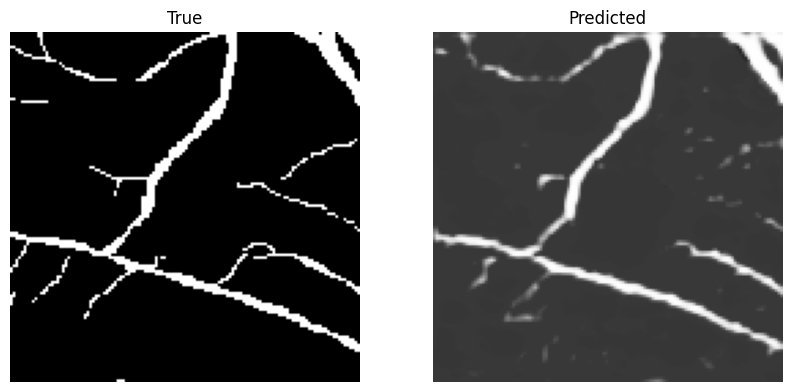


Jaccard: 0.21
Dice: 0.35


Epoch 91: val_loss did not improve from 0.53646
9/9 - 4s - loss: 0.5239 - accuracy: 0.9633 - val_loss: 0.5404 - val_accuracy: 0.9561 - 4s/epoch - 463ms/step
Epoch 92/150

Epoch 92: val_loss did not improve from 0.53646
9/9 - 3s - loss: 0.5214 - accuracy: 0.9615 - val_loss: 0.5399 - val_accuracy: 0.9547 - 3s/epoch - 317ms/step
Epoch 93/150

Epoch 93: val_loss did not improve from 0.53646
9/9 - 3s - loss: 0.5210 - accuracy: 0.9630 - val_loss: 0.5379 - val_accuracy: 0.9542 - 3s/epoch - 320ms/step
Epoch 94/150

Epoch 94: val_loss improved from 0.53646 to 0.53232, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.5170 - accuracy: 0.9616 - val_loss: 0.5323 - val_accuracy: 0.9573 - 3s/epoch - 331ms/step
Epoch 95/150

Epoch 95: val_loss did not improve from 0.53232
9/9 - 4s - loss: 0.5150 - accuracy: 0.9643 - val_loss: 0.5448 - val_accuracy: 0.9513 - 4s/epoch - 478ms/step
Epoch 96/150

Epoch 96: val_loss improved from 0.53232 to 0.53207, saving model to MV2net_DRIV

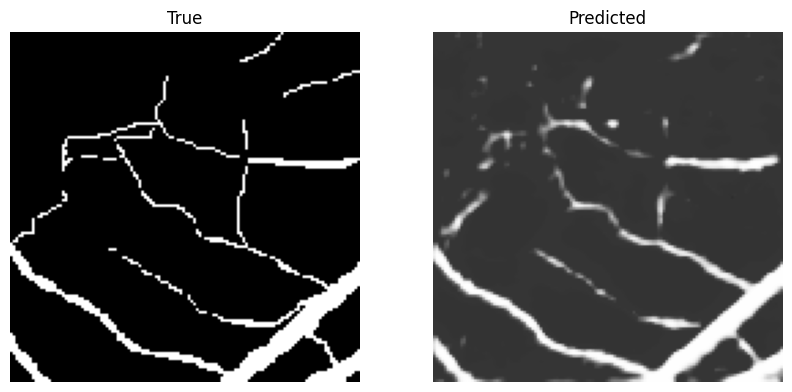


Jaccard: 0.25
Dice: 0.40


Epoch 100: val_loss did not improve from 0.53207
9/9 - 4s - loss: 0.5034 - accuracy: 0.9632 - val_loss: 0.5324 - val_accuracy: 0.9530 - 4s/epoch - 423ms/step
Epoch 101/150

Epoch 101: val_loss did not improve from 0.53207
9/9 - 2s - loss: 0.5001 - accuracy: 0.9649 - val_loss: 0.5351 - val_accuracy: 0.9513 - 2s/epoch - 274ms/step
Epoch 102/150

Epoch 102: val_loss improved from 0.53207 to 0.52019, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.4988 - accuracy: 0.9638 - val_loss: 0.5202 - val_accuracy: 0.9571 - 4s/epoch - 443ms/step
Epoch 103/150

Epoch 103: val_loss did not improve from 0.52019
9/9 - 3s - loss: 0.4991 - accuracy: 0.9641 - val_loss: 0.5206 - val_accuracy: 0.9557 - 3s/epoch - 333ms/step
Epoch 104/150

Epoch 104: val_loss did not improve from 0.52019
9/9 - 2s - loss: 0.4956 - accuracy: 0.9651 - val_loss: 0.5214 - val_accuracy: 0.9558 - 2s/epoch - 274ms/step
Epoch 105/150

Epoch 105: val_loss did not improve from 0.52019
9/9 - 2s - loss: 0.49

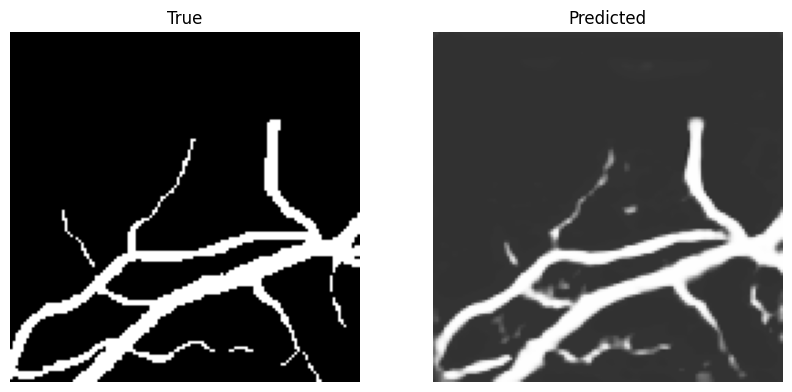


Jaccard: 0.28
Dice: 0.44


Epoch 109: val_loss did not improve from 0.52019
9/9 - 4s - loss: 0.4831 - accuracy: 0.9669 - val_loss: 0.5276 - val_accuracy: 0.9515 - 4s/epoch - 464ms/step
Epoch 110/150

Epoch 110: val_loss improved from 0.52019 to 0.51379, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.4822 - accuracy: 0.9654 - val_loss: 0.5138 - val_accuracy: 0.9567 - 4s/epoch - 451ms/step
Epoch 111/150

Epoch 111: val_loss improved from 0.51379 to 0.51374, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.4806 - accuracy: 0.9654 - val_loss: 0.5137 - val_accuracy: 0.9561 - 3s/epoch - 330ms/step
Epoch 112/150

Epoch 112: val_loss did not improve from 0.51374
9/9 - 3s - loss: 0.4791 - accuracy: 0.9650 - val_loss: 0.5154 - val_accuracy: 0.9524 - 3s/epoch - 278ms/step
Epoch 113/150

Epoch 113: val_loss improved from 0.51374 to 0.51320, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.4759 - accuracy: 0.9667 - val_loss: 0.5132 - val_accuracy: 0.9534 - 3s/epoch - 363ms/step
Epoch 114/1

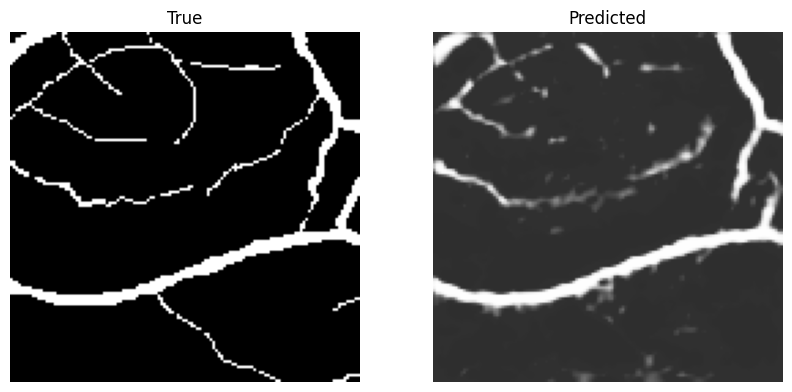


Jaccard: 0.30
Dice: 0.46


Epoch 118: val_loss did not improve from 0.50468
9/9 - 4s - loss: 0.4656 - accuracy: 0.9674 - val_loss: 0.5156 - val_accuracy: 0.9497 - 4s/epoch - 458ms/step
Epoch 119/150

Epoch 119: val_loss did not improve from 0.50468
9/9 - 3s - loss: 0.4629 - accuracy: 0.9669 - val_loss: 0.5186 - val_accuracy: 0.9479 - 3s/epoch - 321ms/step
Epoch 120/150

Epoch 120: val_loss did not improve from 0.50468
9/9 - 3s - loss: 0.4617 - accuracy: 0.9666 - val_loss: 0.5139 - val_accuracy: 0.9516 - 3s/epoch - 358ms/step
Epoch 121/150

Epoch 121: val_loss improved from 0.50468 to 0.50153, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.4595 - accuracy: 0.9674 - val_loss: 0.5015 - val_accuracy: 0.9553 - 4s/epoch - 404ms/step
Epoch 122/150

Epoch 122: val_loss did not improve from 0.50153
9/9 - 3s - loss: 0.4573 - accuracy: 0.9673 - val_loss: 0.5063 - val_accuracy: 0.9528 - 3s/epoch - 320ms/step
Epoch 123/150

Epoch 123: val_loss did not improve from 0.50153
9/9 - 2s - loss: 0.45

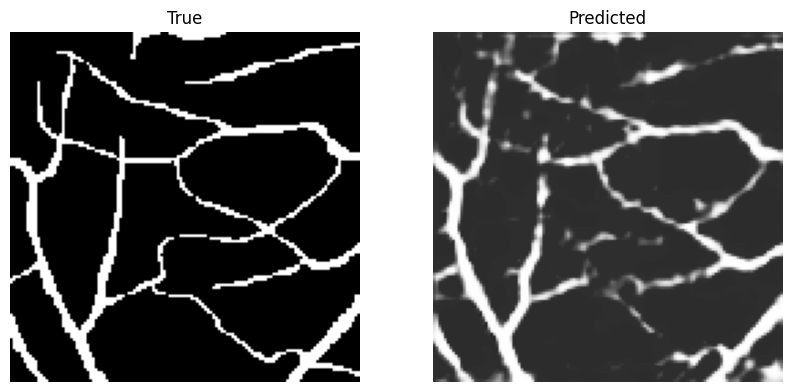


Jaccard: 0.26
Dice: 0.41


Epoch 127: val_loss did not improve from 0.49733
9/9 - 5s - loss: 0.4504 - accuracy: 0.9680 - val_loss: 0.5286 - val_accuracy: 0.9418 - 5s/epoch - 537ms/step
Epoch 128/150

Epoch 128: val_loss did not improve from 0.49733
9/9 - 3s - loss: 0.4477 - accuracy: 0.9681 - val_loss: 0.4978 - val_accuracy: 0.9542 - 3s/epoch - 339ms/step
Epoch 129/150

Epoch 129: val_loss did not improve from 0.49733
9/9 - 3s - loss: 0.4466 - accuracy: 0.9679 - val_loss: 0.5166 - val_accuracy: 0.9466 - 3s/epoch - 324ms/step
Epoch 130/150

Epoch 130: val_loss did not improve from 0.49733
9/9 - 3s - loss: 0.4436 - accuracy: 0.9672 - val_loss: 0.5023 - val_accuracy: 0.9520 - 3s/epoch - 325ms/step
Epoch 131/150

Epoch 131: val_loss did not improve from 0.49733
9/9 - 2s - loss: 0.4426 - accuracy: 0.9690 - val_loss: 0.5311 - val_accuracy: 0.9426 - 2s/epoch - 274ms/step
Epoch 132/150

Epoch 132: val_loss did not improve from 0.49733
9/9 - 3s - loss: 0.4398 - accuracy: 0.9682 - val_loss: 0.5

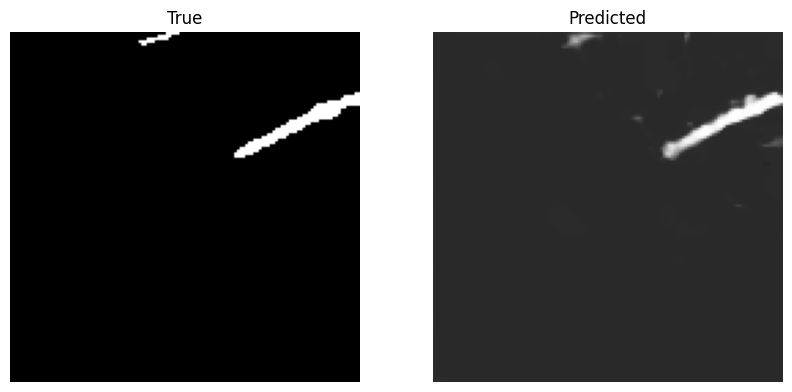


Jaccard: 0.26
Dice: 0.42


Epoch 136: val_loss improved from 0.49569 to 0.48836, saving model to MV2net_DRIVE.h5
9/9 - 5s - loss: 0.4342 - accuracy: 0.9692 - val_loss: 0.4884 - val_accuracy: 0.9546 - 5s/epoch - 547ms/step
Epoch 137/150

Epoch 137: val_loss did not improve from 0.48836
9/9 - 3s - loss: 0.4311 - accuracy: 0.9693 - val_loss: 0.4902 - val_accuracy: 0.9529 - 3s/epoch - 370ms/step
Epoch 138/150

Epoch 138: val_loss did not improve from 0.48836
9/9 - 2s - loss: 0.4297 - accuracy: 0.9687 - val_loss: 0.5029 - val_accuracy: 0.9482 - 2s/epoch - 273ms/step
Epoch 139/150

Epoch 139: val_loss did not improve from 0.48836
9/9 - 3s - loss: 0.4291 - accuracy: 0.9691 - val_loss: 0.5183 - val_accuracy: 0.9433 - 3s/epoch - 323ms/step
Epoch 140/150

Epoch 140: val_loss improved from 0.48836 to 0.48686, saving model to MV2net_DRIVE.h5
9/9 - 4s - loss: 0.4261 - accuracy: 0.9693 - val_loss: 0.4869 - val_accuracy: 0.9521 - 4s/epoch - 409ms/step
Epoch 141/150

Epoch 141: val_loss improved from

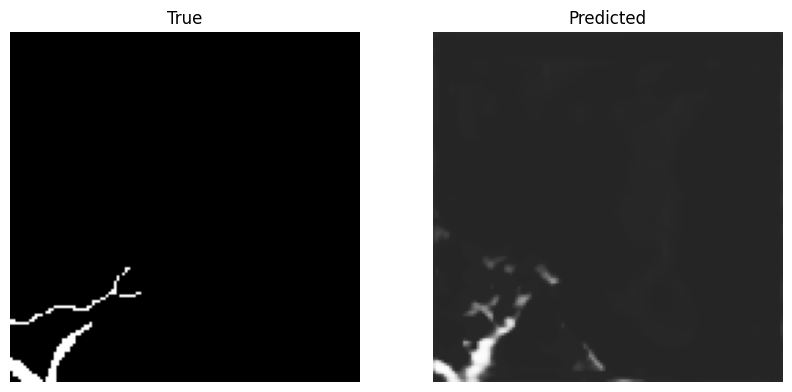


Jaccard: 0.33
Dice: 0.49


Epoch 145: val_loss did not improve from 0.47464
9/9 - 4s - loss: 0.4168 - accuracy: 0.9702 - val_loss: 0.4820 - val_accuracy: 0.9501 - 4s/epoch - 417ms/step
Epoch 146/150

Epoch 146: val_loss improved from 0.47464 to 0.46883, saving model to MV2net_DRIVE.h5
9/9 - 3s - loss: 0.4167 - accuracy: 0.9687 - val_loss: 0.4688 - val_accuracy: 0.9542 - 3s/epoch - 387ms/step
Epoch 147/150

Epoch 147: val_loss did not improve from 0.46883
9/9 - 3s - loss: 0.4159 - accuracy: 0.9709 - val_loss: 0.5040 - val_accuracy: 0.9442 - 3s/epoch - 321ms/step
Epoch 148/150

Epoch 148: val_loss did not improve from 0.46883
9/9 - 3s - loss: 0.4131 - accuracy: 0.9692 - val_loss: 0.4698 - val_accuracy: 0.9538 - 3s/epoch - 324ms/step
Epoch 149/150

Epoch 149: val_loss did not improve from 0.46883
9/9 - 2s - loss: 0.4133 - accuracy: 0.9699 - val_loss: 0.4860 - val_accuracy: 0.9487 - 2s/epoch - 276ms/step
Epoch 150/150

Epoch 150: val_loss did not improve from 0.46883
9/9 - 3s - loss: 0.41

In [171]:
history = model.fit(train, epochs=150, verbose=2,
                    callbacks=[CustomCallback(model, train), checkpointer],
                    validation_data=test)

In [172]:
test_data = DatasetPreprocess(test_image_paths, test_label_paths, output_type='color',
                              batch_size=32, resize_wh=512, num_crops=4,
                              split_dataset=False, is_test=True)

Output a 3 channel image.


In [173]:
test = test_data.get_dataset()

In [174]:
_ = model.evaluate(test)

20/20 [==============================] - 2s 62ms/step - loss: 0.4271 - accuracy: 0.9640


In [175]:
# Create an iterator
dataset_iterator = iter(test)

# Fetch one image-label pair
image, label = next(dataset_iterator)

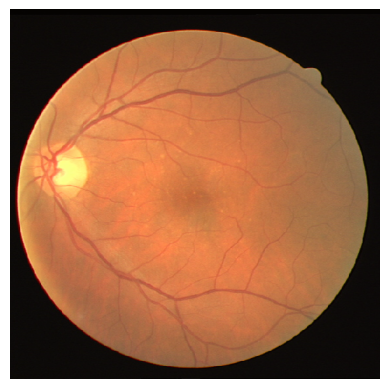

In [176]:
display_image(reconstruct_image(image.numpy()))

1/1 [==============================] - 2s 2s/step


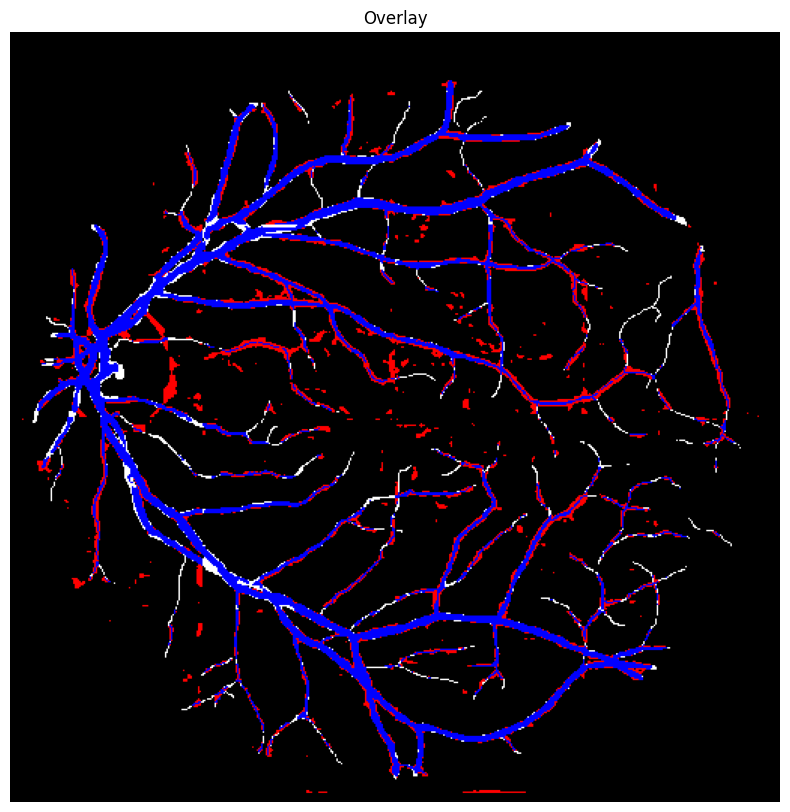

In [177]:
plot_segmentation_results(reconstruct_image(label.numpy()), reconstruct_image(model.predict(image)))